# AUTONOMOUS LINE FOLLOWING gym (ALF-g)

## Goal

In many countries, teenagers have to wait until the age of around 18 before they are granted the autonomy to sit behind the wheel of a car and follow lanes (i.e., lines) arond the road networks of the world. Driving certainly has many complexities aside from the lane-following, and lane-following can be more or less complex depending on the situation, for example:

* Driving on a straight 3-lane highway; **versus**
* Driving down a steep and windy mountain road in heavy rain/sleet.

By contrast, many primary school students are entrusted with programming an autonomous algorithm for a "lego robot" (or similar) to follow a high-contrast line using a downwards facing infra-red (IR) sensor. Certainly there is vastly lower consequences if the "lego robot" goes rogue.

All that said, the goal of this Autonomous Line Following gym (or ALF-g for short) is to find a middle ground between the previous two examples:

---
> **OUR GOAL** is to build-up from scratch a gymnasium-like environment (i.e., a simulation environment) for autonomus driving of a car to follow a continuous-line when using line-detection feedback via a forward facing camera and operating in dynamically challenging conditions.
---

## Outline

In order to achieve this goal, we build-up the environment over the following major sections:

* **First:** we select and define the kinematic bicycle model, which is what we use for modelling a car.
* **Second:** we build a class for simulating a kinematic bicycle model, and we do so in fashion that is devoid of any meaningful operating environment.
* **Third:** we build a class for a road environment (i.e., a line), and we do so in a fashion that is devoid of any robots to drive along the road.
* **Fourth:** we build a gymnasium-like class for road-following simulation (i.e., line-following), and we do this by utilizing the bicycle model and road environment from the previous two sections.

**NOTE:** For the purpose to getting simulating quickly, **you can safely jump** stright to the fourth major section, and then refer back to the other sections if there are details that you wish to check or change.

## Dependencies

We develop ALF-g fully in python and we purposefully choose to avoid "exotic" modules so as to emphasis the from-scratch nature, as well as to make ALF-g easier to run on any computer. The dependencies are: `numpy`, `scipy`, `matplotlib`.

---
---
# SELECTING AND DESCRIBING A KINEMATIC BICYCLE MODEL

The kinematic bicycle model comes in a few different forms depending on the which point is chosen as the origin of the vehicle. The typical choices for the origin are:

* at the rear wheel;
* at the front wheel;
* at some distance between the front and rear wheels that corresponds to the center of gravity location.

We choose the second option because it naturally places the velocity (and hence acceleration) input at the front wheel, which corresponds with a front wheel drive car. We define the following notation for the states, actions, and dimensions of the model:


## Equations-of-motion (eom)

**STATES:**

* $p_x$, $p_y$  :  coordinates of the front wheel in the global coordinate frame , i.e., in the world frame (units: m).

* $\theta$  :  angle of the body of the car relative to the x-axis of the global coordinate frame (units: rad).

**ACTIONS:**

* $v$  :  The velocity of the front wheel in the direction that the wheel is pointing (units: m/s).

* $\delta$  :  The steering angle of the front wheel relative to the body of the car (units: rad).

**PHYSICAL DIMENSIONS:**

* $L$  :  The length of the car between the front and rear wheels (units: m).

Using these definitions, we get the following kinematic bicycle model, for which we readily find online resources that present derivations of this model:

$$
  \frac{\mathrm{d}}{\mathrm{d}t} \, \begin{bmatrix} p_x \\ p_y \\ \theta \end{bmatrix}
    \,=\,
    \begin{bmatrix} \dot{p}_x \\ \dot{p}_y \\ \dot{\theta} \end{bmatrix}
    \,=\,
    \begin{bmatrix}
      v \, \cos\left( \theta + \delta \right)
      \\
      v \, \sin\left( \theta + \delta \right)
      \\
      \frac{1}{L} \, v \, \sin\left( \delta \right)
    \end{bmatrix}
$$

This kinematic bicycle model (as with any kinematic model) allows for instantaneous changes to the velocity and steering inputs, which can be quite unrealistic in terms of the linear acceleration and steering force required to achieve near-instantaneous change. If, external to the model, we limit the allowed rate of change of the actions and use a sufficiently small discrete-time step, then the model can be reasonable.

Alternatively, to make the model slightly more realistic (and without going to a full dynamic model), we can consider $v$ and $\delta$ as states and specify their rate of change as actions:

**RATE OF CHANGE ACTIONS:**
* $\Delta_v$  :  The **acceleration** of the front wheel in the direction that the wheel is pointing (units: m/s^2).

* $\Delta_\delta$  :  The steering **rate** of the front wheel relative to the body of the car (units: rad/s).

The kinematic model from above remains unchanged and is simply augmented with the rate of change equations equations:

$$
  \frac{\mathrm{d}}{\mathrm{d}t} \, \begin{bmatrix} p_x \\ p_y \\ \theta \\ v \\ \delta \end{bmatrix}
    \,=\,
    \begin{bmatrix} \dot{p}_x \\ \dot{p}_y \\ \dot{\theta} \\ \dot{v} \\ \dot{\delta} \end{bmatrix}
    \,=\,
    \begin{bmatrix}
      v \, \cos\left( \theta + \delta \right)
      \\
      v \, \sin\left( \theta + \delta \right)
      \\
      \frac{1}{L} \, v \, \sin\left( \delta \right)
      \\
      \Delta_v
      \\
      \Delta_\delta
    \end{bmatrix}
$$

It is now natural to impose lower and upper bound limits on these rate of change actions, i.e.,

$$
  \begin{aligned}
    \bar{\Delta}_{v,\text{lower}} \,\leq\, \Delta_v \,\leq\,& \bar{\Delta}_{v,\text{upper}}
    \\
    \bar{\Delta}_{\delta,\text{lower}} \,\leq\, \Delta_\delta \,\leq\,& \bar{\Delta}_{\delta,\text{upper}}
  \end{aligned}
$$

These action constraints are imposed on the requested actions before they are fed into the model.

If we define the stacked state vector $s$ and stacked action vector $a$ as:

$$
  s \,=\, \begin{bmatrix} p_x \\ p_y \\ \theta \\ v \\ \delta \end{bmatrix} \in\mathbb{R}^{5}
    \quad \text{  and  } \quad
    a \,=\, \begin{bmatrix} \Delta_v \\ \Delta_\delta \end{bmatrix} \in\mathbb{R}^{2}
    \,,
$$

then the the typical ODE form $\dot{s}=f_c(s,a)$ applies to the equations-of-motion with:

* $f_c : \mathbb{R}^{5} \times \mathbb{R}^{2} \rightarrow \mathbb{R}^{5}$ as the right-hand-side of the equation above.


## Adding stochastic parameters and disturbances

It is important that we always consider multiple sources of stochastic influence on a robotic system and include one or more into a simulation of the system. Stochastic influences capture some of the key differences between the idealized model and the real-world system, with the explicit understanding that these differences can never be precisely known, i.e., stochastic.

We separate the stochastic influences into the following two categories:

* **Parametric uncertainty**.
* **Stochastic disturbances**.

Each category is discussed further below.

### Parametric uncertainty

#### Description:

These are errors in the model that:

* Stay approximately constant over time for one specific real-world robot.
* Are different from robot-to-robot, and possibly even from day-to-day for the same robot.

It is often possible to perform experiments for estimating parameter values for a specific situation, e.g., a calibration procedure. However, there is still some error/uncertainty in the parameter values estimated via such experiments. Hence we need to specify bounds and distribution of parameter values after calibration procedures.

#### Simulation considerations:

As the value of parametric uncertainty remains constant over time:

* The parameter value used in simulation **should remain constant** for the duration of one simulation time horizon.

* The parameter value used in simulation **should change** for each "restart" of the simulation time horizon.

* The true value of the parameter, for a particular simulation time-horizon, **should NOT** be available to the policy.

Hence we analyze such simulation results by analyzing the results across many simulation time-horizon runs, each run using a different parameter value.

#### Examples for the car model:

**Steering offset:**

* Every car turns slightly left or right when the steering angle is requested to be zero (i.e., straight).
* The parameter for modelling this uncertainty can be as simple as a scalar offset that is added to the requested steering angle. As an equation with text labels, this is:

  $$
    \delta \,=\, \delta_{\text{request}} \,+\, \delta_{\text{offset}}
  $$

**Steering gradient:**

* In addition to a steering offset, some cars may have an steering mis-alignment that varies linearly with the requested steering angle
* The parameter for modelling this uncertainty can be a gradient between the requested and actual steering angle. As an equation with text labels, this is:

  $$
    \delta \,=\, \delta_{\text{gradient}} \, \delta_{\text{request}},
  $$

  where we would expected the parameter $\delta_{\text{gradient}}$ to be close to one.

**Rolling resistance:**

* This would capture the combined effect of wheel-to-ground friction, wheel-bearing friction, and drive train friction.
* Such friction is typically modelled as linearly or quadratically proportional to the velocity and opposing the direction of motion.
* In terms of friction being a force, we can model rolling resistance in the kinematic model as a parametric uncertainty influencing the time derivative of the velocity.
* Letting $c_{\text{rr}}$ denote the coefficient of rolling-resistance, we adjust the $\dot{v}$ equation-of-motion as:

  $$
    \dot{v} \,=\, \Delta_v \,-\, c_{\text{rr}} \, v
  $$


* With the addition of the rolling resistance term, we now interpret $\Delta_v$ as an acceleration force action, as opposed to a rate-of-change of velocity input. This captures the fact that rolling resistance leads to a rate-of-change of velocity that is less than $\Delta_v$.

**Total vehicle mass:**

* Although the kinematic model above does not take into account the mass, we anyway mention this parameter because it is very relevant for vehicles.
* For a normal full-size passenger vehicle driving on our road, the mass:

  * Stays approximately constant during each trip.
  * Regularly changes between trips due to a different number of people and pieces of luggage.

* The parameter can be a scalar offset from a baseline value of the mass. For example, the baseline mass could be the tare weight of the vehicle, and the parameter represents the mass of people and luggage being transported by the car.


### Stochastic disturbances

#### Description:

In contrast to the parametric uncertainty above, these are errors in the model that:

  * Randomly fluctuate at every time-instant.
  * The sequence of fluctuations are different every time the system operates.
  * May or may not be correlated in time, for example, a large value of error now may or may not mean a similarly large error value is expected at the next time instant.

  We can try to think of these disturbances as adding white noise to parts of the model. Hence we need to conduct experiments, or further modelling, to get an estimate of the noise distribution, for example: mean, variance, and quartiles.

#### Simulation considerations:

As the sequences of stochastic disturbances continual fluctuates:

* A random number generator function can be used to generate a sequence of values that corresponds to the disturbance on the model.
* A different random seed must be used for every run of the simulation time-horizon.

Hence we analyze such simulation results by analyzing the results across many simulation time-horizon runs, each run using a different seed for generating the (pseudo-)random sequence of stochastic disturbances.

#### Examples for the car model:

* **Rolling resistance:** This could be modelled a white noise on top of a baseline rolling resistance parametric uncertainty.

* **Sensor measurements:** This could be modelled as white noise added to the measurement of speed and/or position.

* **Driving force:** This could be modelled as white noise added to the acceleration (hence force) that is applied to the drive wheel(s).

* **Wind:** This could be modelled as a baseline wind speed in a certain direction plus random fluctuations in the wind speed and its direction.

---
---
# NUMERICAL INTEGRATION OF A KINEAMTIC BICYCLE MODEL

In this section we build up a Python class for specifying the parameters of the car as described by a so-called *kinematic bicycle model*. We implement functions for simulating the time-evolution of the kinematic model via numerical integration.

## Mapping "real world" actions to the kinematic model

It is ideal if the actions expected by our gymnasium (i.e., by our simulator) match the actions that we can command for the specific real world car that we are simulating. This would allows our simulation to be a "drop in" replacement for the real world system, i.e., we do not need to change anything about policies when going from simulation to the real world. Despite this, it is common to program a low-level simulation model that accepts actions that are model variables, and let the higher-level simulation code perform any necessary conversions.

For example, consider a 1/10 scale RC (Remote-controlled) car as the real-world system that we wish to simulate, for which the real-world actions are:

| Action | Units | Range |
|--------|:-----:|:-----:|
| Steering command to a servo | percent | [-100,100] |
| Drive motor duty cycle    | percent | [-100,100] |

The **steering servo** has its own closed-loop feedback for driving the steering to any requested position. This closed-loop steering behaviour can be reasonably represented with the kinematic model by using the $\Delta_\delta$ action for driving the steering to any requested position.

The **drive motor duty cycle** action commands (in essence) the voltage applied to the motor in the range of plus/minus the maximum voltage available. This motor voltage action can**not** be well represented with the kinematic model because simulating a voltage input requires simulating the electrical dynamics of the motor, as well as the motor torque and inertia of the car, which are all aspects that the kinematic model explicitly ignores.

Such 1/10 scale RC cars often require adjustments to the steering trim, and various tolerances mean that it is challenging to measure the lower and upper bounds on steering angles. Hence, the key **parametric uncertainty** that we **choose to include** is a steering offset and a steering gradient.

In terms of **parametric uncertainty**, such 1/10 scale RC cars often require adjustments to the steering trim, and tolerances mean that it is hard to measure the lower and upper bounds on steering angles. Hence, the **key** parametric uncertainty that we **choose to include** is a steering offset and a steering gradient.

---
### For the steering angle:

We put the steering action range and parametric uncertainty into the simulation with the following steps:

* We assume equal steering range on both sides of straight ahead.
* We denote $\bar{\delta}_{\text{max}} > 0$ as the maximum steering angle that can be **requested**.
* Hence the allowable steering **request** range is:

  $$
    -\bar{\delta}_{\text{max}} \leq \delta_{\text{request}} \leq \bar{\delta}_{\text{max}}
  $$

* We convert the steering **request** to a steering "**target**", which is the true steering angle that the simulation moves towards, by applying a parametric uncertainty of steering offset and steering gradient, i.e.:

  $$
    \delta_{\text{target}} \,=\, \delta_{\text{gradient}} \, \delta_{\text{request}} \,+\, \delta_{\text{offset}}
  $$

* We compute at each numerical integration step the action $\Delta_\delta$ that moves the **actual** steering angle towards the **target** while respecting the limits on $\Delta_\delta$, i.e.:

  $$
    \Delta_\delta \,=\, \max\left\{\, \bar{\Delta}_{\delta,\text{lower}} \,,\, \min\left\{\, \frac{\delta_{\text{target}}-\delta}{T_s} \,,\, \bar{\Delta}_{\delta,\text{upper}} \,\right\} \right\},
  $$

  where $Ts$ is the integration time step.

> **NOTE:** All of the "$\delta$"-type quantities here are angles in units of radians.

---
### **For the velocity:**

We put the range of drive motor duty cycle action into the simulation of velocity action with the following steps:

* We neglect that electrical and torque dynamics.
* Assume that the input to the low-level kinematic simulation model is a **request** for a velocity, denoted as $v_{\text{request}}$.
* We assume equal range of velocity **request** of both sides of stationary.
* We denote $\bar{v}_{\text{max}} > 0$ as the maximum velocity that can be **requested**.
* Hence the allowable velocity **request** range is:

  $$
    -\bar{v}_{\text{max}} \leq v_{\text{request}} \leq \bar{v}_{\text{max}}
  $$

* We do not add any uncertainty to the velocity, hence the velocity "**target**" equals the request, i.e., $v_{\text{target}}=v_{\text{request}}$.

* We compute at each numerical integration step the action $\Delta_v$ that moves the **actual** steering angle towards the **target** while respecting the limits on $\Delta_v$, i.e.:

  $$
    \Delta_v \,=\, \max\left\{\, \bar{\Delta}_{v,\text{lower}} \,,\, \min\left\{\, \frac{v_{\text{target}}-v}{T_s} \,,\, \bar{\Delta}_{v,\text{upper}} \,\right\} \right\},
  $$

  where $Ts$ is the integration time step.

> **NOTE:** All of the "$v$"-type quantities here are linear velocities in units of meters per second.
---

## Class description

To keep the class self-contained (and as a reminder to our future-selves), we begin our code with a class declaration and comments that define the states, actions, parameters, and equations of motion.

In [332]:
#!/usr/bin/env python

import numpy as np
from scipy import integrate

class BicycleModelKinematic:
    """
    This class simulates the evolution of a kinematic bicycle model with:

    States:
    - px     :  x-position in the world frame (units: m)
    - py     :  y-position in the world frame (units: m)
    - theta  :  angle of car body relative to x-axis of the world frame (units: rad)
    - v      :  linear velocity of front wheel in the direction it is pointing (units: m/s)
    - delta  : steering angle of front wheel relative of the body of the car (units: rad)

    Actions of the kinematic model:
    - Dv      :  acceleration of the front wheel in the direction it is facing (units: m/s^2)
    - Ddelta  :  steering rate of the front wheel (units: rad/s)

    Actions that can be requested of this simulator:
    - v_request      :  acceleration of the front wheel in the direction it is facing (units: [-100,100] %)
    - delta_request  :  steering rate of the front wheel (units: [-100,100] %)

    Parameters:
    - L  :  wheel-base length, i.e., distance between front and rear axels (units: m)
    - delta_offset : constant error between the requested and actual steering angle (units: rad)
    - delta_gradient : error between the mapping of requested steering angle to actual steering angle (units: none)

    Bounds on the states:
    - No explicit bounds. The request bounds below implicitly limit the v and delta states.

    Bounds on the actions:
    - v_request_max       : upper limit of allowable v request (lower limit is taken as the negative)
    - delta_request_max   : upper limit of allowable delta request (lower limit is taken as the negative)
    - Dv_lower_bound      : lower limit of allowable Dv
    - Dv_upper_bound      : upper limit of allowable Dv
    - Ddelta_lower_bound  : lower limit of allowable Ddelta
    - Ddelta_upper_bound  : upper limit of allowable Ddelta
    """

## Initialization function

We now define the initialization function for our class. To have a somewhat generic architecture for our robot models, we expect, as an input argument for initialization, a dictionary with an appropriately named key for each parameter of the model.

Additionally, we initialize class variables for the states. We choose to use a separate property for each state for easier readability. An alternative option would be a `numpy` array for the state vector, which can be computationally faster and can lead to mistakes and/or confusion and/or misunderstandings about what state is represented by each index of the state vector.

In [333]:
class BicycleModelKinematic(BicycleModelKinematic):

    @classmethod
    def __init__(self, model_parameters):
        """
        Initialization function for the "BicycleModelKinematic" class.

        Parameters
        ----------
            model_parameters : float
                A dictionary for the constant paramters that describe the
                kinematic bicycle model. See the class definition above for the
                notation and defintion of each parameter.

        Returns
        -------
        Nothing
        """
        # Extract the parameters
        # > For vehicle dimension
        self.L = model_parameters["L"]
        # > For parametric uncertainty in the steering angle
        self.delta_offset = model_parameters["delta_offset"]
        self.delta_gradient = model_parameters["delta_gradient"]
        # > For limits on the steering angle that can be requested
        self.delta_request_max = model_parameters["delta_request_max"]
        # > For limits on the velocities that can be requested
        self.v_request_max = model_parameters["v_request_max"]
        # > For limits on the rate-of-change of velocity
        self.Dv_lower_limit = model_parameters["Dv_lower_limit"]
        self.Dv_upper_limit = model_parameters["Dv_upper_limit"]
        # > For limits on the rate-of-change of steering angle
        self.Ddelta_lower_limit = model_parameters["Ddelta_lower_limit"]
        self.Ddelta_upper_limit = model_parameters["Ddelta_upper_limit"]

        # Construct a dictionary of the model parameters are needed for the equations of motion
        # > This allows the numerical integration function to be written in a general fashion that is essential identical for any system.
        self.model_params_for_eom = { "L": self.L }

        # Initialize the state variables
        # > These are for readability when accessing this class
        self.px    = 0
        self.py    = 0
        self.theta = 0
        self.v     = 0
        self.delta = 0

        # Initialize the action variables
        self._Dv     = 0
        self._Ddelta = 0

        # Initialize the actions requested
        self._v_request     = 0
        self._delta_request = -self.delta_offset

> **NOTE:** We leave it as an exercise to add error checking and corresponding error messages for the parameters. For example: that the length parameter must be positive; or that a lower action limit must be less than its respective upper action limit.

## Reset function

We define a reset function so that the car can be re-initialized to a specific state that is specified by the input arguments. We choose to default to zero any argument that is not provided.

In [334]:
class BicycleModelKinematic(BicycleModelKinematic):

    @classmethod
    def reset(self, px = 0, py = 0, theta = 0, v = 0, delta = 0):
        """
        Reset the states, actions, and requested actions.

        Parameters
        ----------
            px : float
                Value to assign the "px" state for the reset (units: m)
            py : float
                Value to assign the "py" state for the reset (units: m)
            theta : float
                Value to assign the "theta" state for the reset (units: radians)
            v : float
                Value to assign the "v" state for the reset (units: m/s)
            delta : float
                Value to assign the "delta" state for the reset (units: radians)

        Returns
        -------
        Nothing
        """
        # Set the states to the values provided
        # > Impose any lower and upper of the state elements
        self.px    = px
        self.py    = py
        self.theta = theta
        self.v     = v
        self.delta = max( -self.delta_request_max, min( delta , self.delta_request_max ))

        # Reset the actions and requested actions to zero
        self._Dv     = 0
        self._Ddelta = 0
        self._Dv_request     = 0
        self._Ddelta_request = 0

## Set actions function


In order to impose the lower and upper limits on the action requested, we require their values to be set through this function. Note that the function name refers to action *requests* because, as explained above, these are natural actions for a car. The model implementation that follows provides a closed-loop that ensure the actual states (or $v$ and $\delta$ track towards their requested values respectively.

In [335]:
class BicycleModelKinematic(BicycleModelKinematic):

    @classmethod
    def set_action_requests(self, v_request = 0, delta_request = 0):
        """
        Set the action request values, clipping them to their allowable range.

        Parameters
        ----------
            v_request : float
                The requested value for the velocity, i.e., the target.
                (units: m/s)
            delta_request : float
                The requested value for the steering angle, i.e., the target.
                (units: radians)

        Returns
        -------
        Nothing
        """
        # Clip the actions to their respective request limits
        self._v_request     = max( -self.v_request_max    , min( v_request    , self.v_request_max     ))
        self._delta_request = max( -self.delta_request_max, min( delta_request, self.delta_request_max ))

## Equations-of-motion function

We now add a function that computes (and returns) the right-hand-side of the equations-of-motion established in the section above, i.e., computes (and returns) $f_c(s,a)$. Hence, this function:

* Takes input arguments of the state, actions, and relevant model parameters;
* Returns the value of the time derivative of the state, i.e., $f_c(s,a)$ from the equations-of-motion.

This function accepts the states and actions as a numpy array and returns the time derivative as a numpy array. We do this because it allow us to write the code for our numerical integration function (see the next section) in a fashion that works exactly the same for any system model.

Additionally, the function expects a dictionary containing the necessary parameters of the model, i.e., `model_params`. We do this for the same reason as above, i.e., it allows the numerical integration function to be written very generally. This also has the benefit of making clear which parameters appear in the equations-of-motion (e.g., dimensions and masses), and which parameters are for other aspects of the model (e.g., lower and upper bound limits on the actions).

This equations-of-motion (*eom*) function is at the core of our numerical integration function that we write next. Hence it can be important to optimize this *eom* function if we wish to perform a large number of simulations.

---
> **NOTE**
> Similar to a comment earlier on this page, using `numpy` arrays for the state and action can cause mistakes and/or confusion and/or misunderstandings about what is represented by each index of the state and action vectors. This is justified here because this function is internal to the class and hence its internal syntax is hidden from any code that use this kinematic bicycle class for a simulation. The numerical integration function below is the one that needs to be readily understood by a simulation code that uses this kinematic bicycle class.
---



In [336]:
class BicycleModelKinematic(BicycleModelKinematic):

    @staticmethod
    def eom_kinematic_bicycle(t, s, a, model_params):
        """
        Compute the equations-of-motion (eom) for the kinematic bicycle model.

        The eom for the bicycle, derived for the location of the front wheel, are:

        px_dot    = v * cos(theta+delta)
        py_dot    = v * sin(theta+delta)
        theta_dot = (1/L) * v * sin(delta)
        v_dot     = Dv
        delta_dot = Ddelta

        See the class definition above for the meaning of this notation.

        Parameters
        ----------
            t : float
                Time for a time-varying eom. This is not used by this function
                because the kinematic bicycle model is time-invariant. However,
                "t" is required as an input parameters because it is expected by
                the scipy.integrate numercial integration functions.
            s : numpy array
                The states, with ordering convention: [px, py, theta, v, delta]
                This is expected to be a one-dimensional array.
            a : numpy array
                The actions, with ordering convention: [Dv, Ddelta]
                This is expected to be a one-dimensional array.
            model_params : dictionary
                A dictionary contain the constant model parameters that appear
                in the eom. For the kinematic bicycle model is only the length
                "L" between the front and rear axles.

        Returns
        -------
        s_dot : numpy array
            The time deriviative of the state, i.e., "s dot", with the same
            ordering convention as "s", i.e.,:
            [px_dot, py_dot, theta_dot, v_dot, delta_dot]
        """
        # Compute and return "state dot":
        s_dot = np.array([
          s[3] * np.cos(s[2]+s[4]) ,
          s[3] * np.sin(s[2]+s[4]) ,
          s[3] * np.sin(s[4]) / model_params["L"] ,
          a[0] ,
          a[1] ,
          ], dtype=np.float32)
        return s_dot

## Numerical integration function function

We now write the function that is at the core of our numerical simulations. We start the function with a doc-string that describes the input arguments of the function and the values it returns. In essence, the function:

* Takes in the current state and zero-order-hold action; and
* Runs the specified numerical integration method for the specified sample time.
* Returns the approximated value of the state evolution at the end of the sample time.

---
> **IMPORTANT::**
> The input argument `num_steps` (see code below) is used by the function to perform multiple sequential integration time steps. Hence, if the "outer-loop" that calls this function only requires long-duration time steps (for example 1 second), then this "number of steps" argument can be used split that up into multiple smaller time steps for improved accuracy and/or stability of the integration method.
---


In [337]:
class BicycleModelKinematic(BicycleModelKinematic):

    @classmethod
    def perform_integration_step(self, Ts, method, num_steps = 1, should_update_state = False):
        """
        Performs numerical integration, using multiple time-steps if specified, to approximate the state after Ts seconds.

        Parameters
        ----------
            Ts : float
                duration for each integration time step (units: seconds).
            method : string
                the numerical integration technique to use.
            num_steps : integer (default = 0)
                the number of integration time steps to perform.
            should_update_state : bool (default = False)
                Boolean flag for whether the class variable for the state should be updated with the result to be returned

        Returns
        -------
        px, py, theta, v, delta : float, float, float, float, float
            The state approximation after the system evolves for Ts seconds, returned as each element of the state separately.
        """

        # Convert the requested actions into the kinematic model actions
        # > For steering angle:
        delta_target = self.delta_gradient * self._delta_request + self.delta_offset
        Ddelta_target = (delta_target - self.delta) / (Ts*num_steps)
        self._Ddelta = max( self.Ddelta_lower_limit , min( Ddelta_target , self.Ddelta_upper_limit ))

        # > For velocity:
        v_target = self._v_request
        Dv_target = (v_target - self.v) / (Ts*num_steps)
        self._Dv = max( self.Dv_lower_limit , min( Dv_target , self.Dv_upper_limit ))

        # Construct the state vector
        s = np.array([self.px, self.py, self.theta, self.v, self.delta], dtype=np.float32)

        # Construct the action vector
        a = np.array([self._Dv, self._Ddelta], dtype=np.float32)

        # Get the (pointer to the) model parameters into a local variable
        model_params = self.model_params_for_eom

        # Iterate over the requested number of time step
        for i_step in np.arange(0,num_steps):

            # Switch for the requested integration method
            if (method == "euler"):
                # Compute in one line
                s_plus = s + Ts * self.eom_kinematic_bicycle(0, s, a, model_params)

            elif (method == "midpoint"):
                # Compute Euler’s method for half a time step
                s_half = s + 0.5 * Ts * self.eom_kinematic_bicycle(0, s, a, model_params)
                # Compute full step based on gradient at the half step state (i.e., at the midpoint)
                s_plus = s + Ts * self.eom_kinematic_bicycle(0, s_half, a, model_params)

            elif (method == "huen"):
                # Compute Euler’s method for a full time step
                s_euler = s + Ts * self.eom_kinematic_bicycle(0, s, a, model_params)
                # Compute update based on half gradient at the start and the end
                s_plus = s + 0.5* Ts * (self.eom_kinematic_bicycle(0, s, a, model_params) + self.eom_kinematic_bicycle(0, s_euler, a, model_params))

            elif (method == "rk4"):
                # Compute the eom for the RK4 sequence of states
                m1 = self.eom_kinematic_bicycle(0, s, a, model_params)
                m2 = self.eom_kinematic_bicycle(0, s+0.5*Ts*m1, a, model_params)
                m3 = self.eom_kinematic_bicycle(0, s+0.5*Ts*m2, a, model_params)
                m4 = self.eom_kinematic_bicycle(0, s+Ts*m3, a, model_params)
                # Compute the state update
                s_plus = s + (1/6) * Ts * (m1 + 2*m2 + 2*m3 + m4)

            elif (method == "rk45"):
                # Python function links:
                # > scipy.integrate.RK45: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.RK45.html#scipy.integrate.RK45
                # > scipy.integrate.solve_ivp: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp

                # Call the RK45 method
                sol = integrate.solve_ivp( self.eom_kinematic_bicycle, [0,Ts], s, method="RK45", t_eval=None, args=[a, model_params], vectorized=False)

                # Copy across the solution
                s_plus = np.copy(sol.y[:,-1])

            else:
                # Log this as an error
                print("ERROR: integration method \"" + str(method) + "\" not recognized")
                s_plus = np.zeros(s.shape(), dtype=np.float32)

            # Update the state variable that is local to this function
            s = np.copy(s_plus)

        # Numerical integration is now complete

        # Update the class variable (if requested)
        if (should_update_state):
            self.px    = s[0]
            self.py    = s[1]
            self.theta = s[2]
            self.v     = s[3]
            self.delta = s[4]

        # Return the state components
        return s[0], s[1], s[2] , s[3] , s[4]

## Get actions function

In order to access the $\Delta_v$ and $\Delta_\delta$ actions computed as part of the numerical integration step, we add a function for retrieving their values.

In [338]:
class BicycleModelKinematic(BicycleModelKinematic):

    @classmethod
    def get_actions(self):
        """
        Get the value of the current actions

        Parameters
        ----------
            None

        Returns
        -------
        Dv, Ddelta : float, float
            The rate-of-change actions.
        """
        # Return the actions
        return self._Dv, self._Ddelta

## Simulation script outline

Now that we have completed a kinematic bicycle model class in the previous sub-sections, due diligence dictates that we put that class into a simple open-loop simulation to verify that the model behaves as expected. To do this, we:

1. Specify all the details of the simulations we wish to perform.
2. Initialize an instance of the kinematic bicycle class.
3. Set the state to its initial condition.
4. Iterate over a moderately long simulation time-horizon, where at each step we:
  a. Select a steering action that oscillates over time (i.e., swerving left-and-right)
  b. Call the integration function of the bicycle model at each time step.
  c. Keep a record of the state and action trajectoires.
5. Perform the previous steps for multiple different integration methods, recording the total computation time for each one.
6. Plot everything to get a visual comparison of the different integration methods.

## Prepare the details of the simulation study to be performed

The following is the beginning of a stand along script for setting up the parameters for simluation, i.e., the following code performs Steps 1 and 2 of the above "simulation script outline". Ideally, the comments and variable name make the details self-explanatory,

> **NOTE:**
> Depending on how you are assembling and running the code provided here, you may choose to save the kinematic bicycle class into a file named `BicycleModelKinematic.py` (for example)m and then import it.

In [339]:
import numpy as np
from time import perf_counter
#import BicycleModelKinematic


# Specify simulation length by:
# > Number of steps
N_sim = 200
# > Time increment per simulation step (units: seconds)
Ts_sim = 0.1

# Specify the integration methods to test
integration_methods = ["euler", "midpoint", "huen", "rk4", "rk45"]

# Specify the parameters required by the Kinematic Bicycle class
bike_model_parameters = {
    "L" : 1,
    "delta_offset" : 1 * np.pi/180,
    "delta_gradient" : 1,
    "delta_request_max" : 45 * np.pi/180,
    "v_request_max" : 5,
    "Dv_lower_limit" : -2,
    "Dv_upper_limit" : 2,
    "Ddelta_lower_limit" : -90 * np.pi/180,
    "Ddelta_upper_limit" :  90 * np.pi/180,
    }

# Specify the initial condition
px_init    = 0
py_init    = 0
theta_init = -30 * np.pi/180
v_init     = 0
delta_init = 0

# Initilalize an instance of the Bike Model class
bike_model = BicycleModelKinematic(bike_model_parameters )

# For convenience, compute the number of integration methods
num_int_methods = len(integration_methods)

# Initialise array for storing the state and action trajectories
px_traj    = np.empty([num_int_methods, N_sim+1], dtype=np.float32)
py_traj    = np.empty([num_int_methods, N_sim+1], dtype=np.float32)
theta_traj = np.empty([num_int_methods, N_sim+1], dtype=np.float32)
v_traj     = np.empty([num_int_methods, N_sim+1], dtype=np.float32)
delta_traj = np.empty([num_int_methods, N_sim+1], dtype=np.float32)

Dv_traj     = np.empty([num_int_methods, N_sim], dtype=np.float32)
Ddelta_traj = np.empty([num_int_methods, N_sim], dtype=np.float32)

v_request_traj     = np.empty([num_int_methods, N_sim], dtype=np.float32)
delta_request_traj = np.empty([num_int_methods, N_sim], dtype=np.float32)

sim_time_per_method = np.empty([num_int_methods,], dtype=np.float32)

## Run the simulations

Now that we have everything initialized, we can go ahead perform the simulation, i.e., Steps 3, 4, and 5 from the above, repeated here for convenience:

3. Set the state to its initial condition.
4. Iterate over a moderately long simulation time-horizon, where at each step we:
  a. Select a steering action that oscillates over time (i.e., swerving left-and-right)
  b. Call the integration function of the bicycle model at each time step.
  c. Keep a record of the state and action trajectoires.
5. Perform the previous steps for multiple different integration methods, recording the total computation time for each one.

The following code performs these steps.

In [340]:
# Iterate over the integration methods
for int_method_idx, int_method  in enumerate(integration_methods):

    # Set the integration method of the simulator
    bike_model.integration_method = int_method

    # Set the initial condition
    bike_model.reset(px = px_init, py = py_init, theta = theta_init, v = v_init, delta = delta_init)

    # Put the initial condition into the first entry of the state trajectory results
    px_traj[int_method_idx,0]    = px_init
    py_traj[int_method_idx,0]    = py_init
    theta_traj[int_method_idx,0] = theta_init
    v_traj[int_method_idx,0]     = v_init
    delta_traj[int_method_idx,0] = delta_init

    # Record the start time
    start_time = perf_counter()

    # Iterate over the simulation horizon
    for k_sim_step in np.arange(0,N_sim):

        # Compute the action for this time step
        # > Oscillating velocity request
        v_request = 1.5 + 0.5 * np.sin( 2*np.pi * k_sim_step * Ts_sim / 12 )
        # > Oscillating steering request
        delta_request = (0 + 20 * np.sin( 2*np.pi * k_sim_step * Ts_sim / 4 )) * (np.pi/180)

        # Set the action request for Bike Model
        bike_model.set_action_requests(v_request = v_request, delta_request = delta_request)

        # Perform one integration step
        bike_model.perform_integration_step(Ts_sim, int_method, num_steps = 1, should_update_state = True)

        # Store the results
        # > For the action requests
        v_request_traj[int_method_idx, k_sim_step]     = v_request
        delta_request_traj[int_method_idx, k_sim_step] = delta_request
        # > For the "actual" actions
        Dv, Ddelta = bike_model.get_actions()
        Dv_traj[int_method_idx, k_sim_step]     = Dv
        Ddelta_traj[int_method_idx, k_sim_step] = Ddelta
        # > For the updated state
        px_traj[int_method_idx, k_sim_step+1]    = bike_model.px
        py_traj[int_method_idx, k_sim_step+1]    = bike_model.py
        theta_traj[int_method_idx, k_sim_step+1] = bike_model.theta
        v_traj[int_method_idx, k_sim_step+1]     = bike_model.v
        delta_traj[int_method_idx, k_sim_step+1] = bike_model.delta

    # Record the end time of this simulation run
    end_time = perf_counter()

    # Store the timing results
    this_sim_time = end_time - start_time
    sim_time_per_method[int_method_idx] = this_sim_time

    # Print out a simple statement of the timing results
    print("Completed simulation of " + str(N_sim) + " time steps for method = " + "{:<10}".format(int_method) + ", in " + '{0:10.6f}'.format(this_sim_time) + " seconds." )

Completed simulation of 200 time steps for method = euler     , in   0.033306 seconds.
Completed simulation of 200 time steps for method = midpoint  , in   0.034525 seconds.
Completed simulation of 200 time steps for method = huen      , in   0.037013 seconds.
Completed simulation of 200 time steps for method = rk4       , in   0.059742 seconds.
Completed simulation of 200 time steps for method = rk45      , in   0.278447 seconds.


## Plot some visualisation of the results

Now that our simulations are complete and we have stored the data, it is time to plot some visualizations of the results, i.e., Step 6 from above:

6. Plot everything to get a visual comparison of the different integration methods.

We can and should consider many different visualizations so allow us to fully interpret the results, especially if the simulation study covers a range of parametric uncertainty and/or stochastic disturbance. For the purpose of this example, we keep the plotting simple and focus on the comparison between integration methods.

We expect all the simulations to have the same trajectory of $\Delta_v$ and $\Delta_\delta$, hence we first confirm this to be true.

For the main comparison, we plot the $(x,y)$ trajectory in space and the $(x,y,\theta)$ trajectories in time.

For all the visualization, we import the plotting module and initialize a vector of the simulation times in seconds.

In [341]:
import matplotlib.pyplot as plt

# Construct a vector of the times
time_values = np.arange(start=0, stop=(N_sim+0.5)*Ts_sim, step=Ts_sim, dtype=np.float32)

The following plots the trajectory in (x,y) space for all the integration methods. Additionally, we plot separately the x and y trajectories over time. These plots are useful for providing a visual comparison between the numerical integration techniques.

Text(0.5, 1.0, '(x,y) trajectories for each integration method')

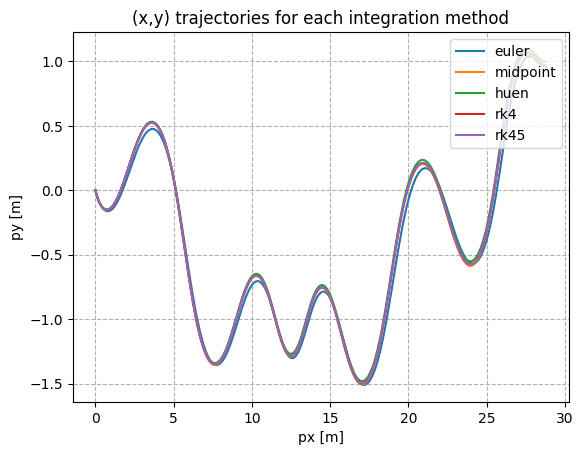

In [342]:
# ==================================
# PLOT THE TRAJECTORY IN (x,y)-SPACE

# > Open a figure
fig, axs = plt.subplots(1, 1, sharex=True, sharey=False, gridspec_kw={"hspace": 0.2, "wspace": 0.4})

# > Plot speed the results
# Iterate over the integration methods
for int_method_idx, int_method  in enumerate(integration_methods):
    axs.plot(px_traj[int_method_idx,:],py_traj[int_method_idx,:],label=int_method)

# Make things look nice
axs.set_xlabel('px [m]')
axs.set_ylabel('py [m]')
axs.legend(loc = 'upper right')
axs.grid(visible=True, which="both", axis="both", linestyle='--')

# Add a/ title
axs.set_title("(x,y) trajectories for each integration method")

# > Save the plot
#fig.savefig("xy_trajectory.pdf")

Now plot the state trajectories over time for providing a different visual perspective of the simulation result.

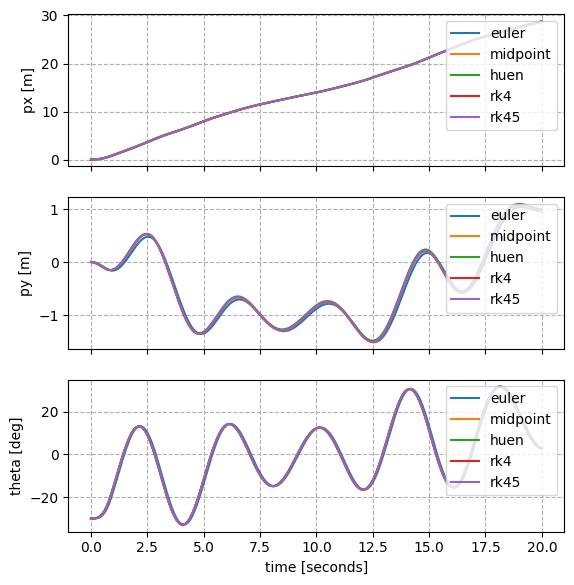

In [343]:
# ================================================
# PLOT THE STATE AND ACTION TRAJECTORIES OVER TIME

# > Open a figure
fig, axs = plt.subplots(3, 1, sharex=True, sharey=False, gridspec_kw={"hspace": 0.2, "wspace": 0.4})

# > Make the figure taller
temp_size = fig.get_size_inches()
fig.set_size_inches(temp_size[0], temp_size[1]*1.4)

# > Plot x-position of the car body
for int_method_idx, int_method  in enumerate(integration_methods):
    axs[0].plot(time_values,px_traj[int_method_idx,:],label=int_method)

axs[0].set_ylabel('px [m]')
axs[0].legend(loc = 'upper right')
axs[0].grid(visible=True, which="both", axis="both", linestyle='--')

# > Plot y-position of the car body
for int_method_idx, int_method  in enumerate(integration_methods):
    axs[1].plot(time_values,py_traj[int_method_idx,:],label=int_method)

axs[1].set_ylabel('py [m]')
axs[1].legend(loc = 'upper right')
axs[1].grid(visible=True, which="both", axis="both", linestyle='--')

# > Plot angle of the car body
# > Plot x-position of the car body
for int_method_idx, int_method  in enumerate(integration_methods):
    axs[2].plot(time_values,theta_traj[int_method_idx,:]*(180/np.pi),label=int_method)

axs[2].set_ylabel('theta [deg]')
axs[2].legend(loc = 'upper right')
axs[2].grid(visible=True, which="both", axis="both", linestyle='--')

# > Add horizontal axis label
axs[2].set_xlabel('time [seconds]')

# Add an overall figure title
fig.suptitle = "Result for 1 integration method"

# > Save the plot
#fig.savefig("file_name" + ".pdf")

As a double-check of for how the velocity and steering angle track with their requested values, we now plot these for just one of the integration methods.

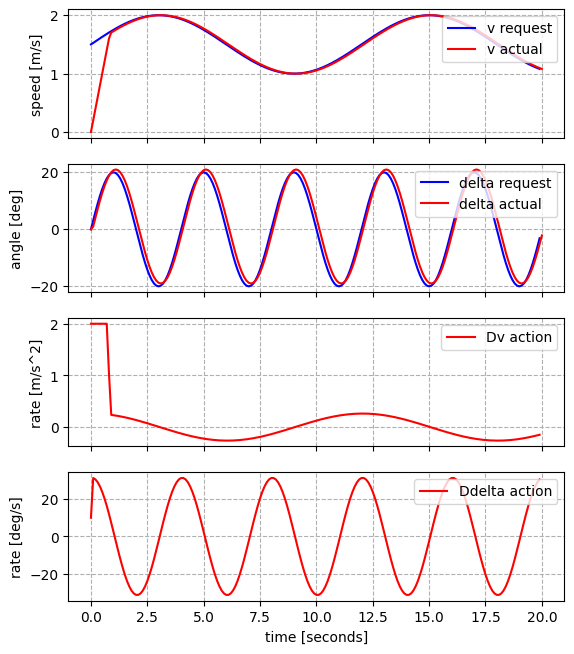

In [344]:
# ================================================
# PLOT THE STATE AND ACTION TRAJECTORIES OVER TIME

int_idx_to_plot = 0

# > Open a figure
fig, axs = plt.subplots(4, 1, sharex=True, sharey=False, gridspec_kw={"hspace": 0.2, "wspace": 0.4})

# > Make the figure taller
temp_size = fig.get_size_inches()
fig.set_size_inches(temp_size[0], temp_size[1]*1.6)

# > Plot speed the results
axs[0].plot(time_values[0:N_sim],v_request_traj[int_idx_to_plot,:],color="blue",label="v request")
axs[0].plot(time_values,v_traj[int_idx_to_plot,:],color="red", label="v actual")
axs[0].set_ylabel('speed [m/s]')
axs[0].legend(loc = 'upper right')
axs[0].grid(visible=True, which="both", axis="both", linestyle='--')

# > Plot steering angle the results
axs[1].plot(time_values[0:N_sim],delta_request_traj[int_idx_to_plot,:]*(180/np.pi),color="blue",label="delta request")
axs[1].plot(time_values,delta_traj[int_idx_to_plot,:]*(180/np.pi),color="red", label="delta actual")
axs[1].set_ylabel('angle [deg]')
axs[1].legend(loc = 'upper right')
axs[1].grid(visible=True, which="both", axis="both", linestyle='--')

# > Plot rate-of-change action for velocity
axs[2].plot(time_values[0:N_sim],Dv_traj[int_idx_to_plot,:],color="red",label="Dv action")
axs[2].set_ylabel('rate [m/s^2]')
axs[2].legend(loc = 'upper right')
axs[2].grid(visible=True, which="both", axis="both", linestyle='--')

# > Plot rate-of-change action for steering
axs[3].plot(time_values[0:N_sim],Ddelta_traj[int_idx_to_plot,:]*(180/np.pi),color="red", label="Ddelta action")
axs[3].set_ylabel('rate [deg/s]')
axs[3].legend(loc = 'upper right')
axs[3].grid(visible=True, which="both", axis="both", linestyle='--')


# > Add horizontal axis label
axs[3].set_xlabel('time [seconds]')

# Add an overall figure title
fig.suptitle = "Result for 1 integration method"

# > Save the plot
#fig.savefig("file_name" + ".pdf")

---
---
# AUTONOMOUS ROAD-DRIVING ENVIRONMENT

The intention of this environment is to simulate autonomous driving on a long stretch of road the includes many curves. Such an environment needs to provide the following:

* A description and visualization of the road relative to some fixed 2D "world" coordinate frame.

* A function that: for any given coordinates in the 2D world frame, computes the closest point on the road.

* A fuction that: for any given point on the road, computes a sequnce of regularly-spaced points on the road going forwards from the starting point.

* A function that: for any set of points in the 2D world frame coordinates, computes how a camera on the car would observe those points, i.e., the pixel coordinates that each point maps to.


To development an environment with the aspects discussed above, we build up the code the following sections:

* Section 1: We describe a format for specfying a road as a series of curves and straights, and we begin a class for the environment.

* Section 2: We implement class functions to construct a complete road as a sequence of elements, and we process those road elements into a format that assists for finding the closest point on the road.

* Section 3: To visually confirm the road construction, we implement a function for plotting the road onto a given axis handle.

* Section 4: We implement a class function to find the closest point on the road.

* Section 5: We implement the computing of a sequence of points along the road, as well as the transformation of coordinates into another frame of reference, e.g., the body frame of the vehicle driving along the road.

* Section 6: We implement the transformations from 2D body-frame cartesian-coordinates to 2D camera-frame pixel-coordinates.




## Road description and class initialization

We describe the road by a sequence of road elements that are specified by a curvature and a length, which we denote as:

* $c_i \,\in\, \left\{ (-\infty,-\epsilon_c] \cup 0 \cup [\epsilon,\infty) \right\} \subset \mathbb{R}$ is the curvature of the road element with:
  * Positive curvature being a clockwise curve (looking from above).
  * Negative curvature being a counter-clockwise curve.
  * Zero curvature being a straight line.
  * Curvature is the inverse of the radius, i.e., $r_i = 1/c_i$ (for $c_i\neq0$).
  * We choose to use curvature instead of radius so that straight lines are described by 0 curvature instead of infinite radius.
  * To avoid extremely large radii in subsequent processing, we enforce any non-zero the absolute curvature to be greater than some minimum value, which we denote as $\epsilon_c > 0$

* $l_i \,\in\, (0,\infty) \subset \mathbb{R}$ is the length along the road element.
  * For a straight road element (i.e., with $c_i=0$), this is simply the euclidean distance between the start and end points of the element.
  * For a curved road element (i.e., with |$c_i|>\epsilon_c$), we introduce:

* $\phi_i \in \,\in\, (0,\infty) \subset \mathbb{R}$ is the length of the road element, specified in terms of the angle that it spans.
  * Hence, the length $l_i$ of a curved road element is computed as it arc length: $l_i = \phi_i r_i = \phi_i / c_i$.
  * We can thus allow the length of a curved road element to be specified by either it arc length $l_i$ or its angle range $\theta_i$.

* $i \,\in\, \left\{ 0 , \mathbb{Z}_{+} \right\}$ is the index for counting the raod element from $0$ upto $N_e$.

We begin the environment class with a few standard imports, a class statement, and a bulk comment describing the above



In [345]:
import numpy as np

class RoadEnv:
    """
    This class provides a road-like environment that is described by a sequnce
    of straight-line and curved elements. The method for constructing a complete
    road ensure that the road is continuous and smooth. The class also includes
    function for computing the details of the road relative to a given query
    point, i.e., the details that a car may be able to measure while driving
    along the road.

    Quantities that fully specify each road element
    - c_i : the curvature of the road element (units: 1/m).
    - l_i : the length of the road element (units: m).

    From c_i and l_i, the following quantities are computed:
    - phi_i      : the angluar span of curved road elements as theta_i = l_i * c_i, equal to NaN for a straight-line element (units: radians)
    - isStraight_i : A flag for whether the road element is straight, by checking |c_i| < epsilon (units: boolean)

    Additional quantities are derived from the above values as they are convenient for the
    functions that process the road:
    - start_point_i        : (x,y) coordinates of the start of the road element (units: m).
    - end_point_i          : (x,y) coordinates of the end   of the road element (units: m).
    - start_angle_i        : angle (realtive to world frame x-axis) of the tangent to the road element at its start point (units: radians).
    - end_angle_i          : angle (realtive to world frame x-axis) of the tangent to the road element at its end.  point (units: radians).
    - arc_center_i         : (x,y) coordinates of the center point of a curved road element (units: m).
    - l_total_at_end_i     : the total length of the road at the end point that the road element (units: m).
    - start_hyperplane_A_i : the unit normal vector that point in the opposite direction of start angle (units: m).
    - start_hyperplane_b_i : the offset value such that the hyperplane pass through the start point (units: m).
    - end_hyperplane_A_i   : the unit normal vector that point in the opposite direction of end angle (units: m).
    - end_hyperplane_b_i   : the offset value such that the hyperplane pass through the end point (units: m).
    """

We now add the class initialization function, where we initialize semome empty vectors for the properties of each road element. In additiona to the properties of a road element described above, we initialize empty array for additional properties that are convenient for later usage, which are:

* The number of road elements.
* The start point and end point of the road element, in 2D world coordinates.
* The arc center of curved road elements, in 2D world coordinates.
* The start and end angle of the road element, relative to the positive x-axis of the world frame, denotes as $\theta_{i,\text{start}}$ and $\theta_{i,\text{end}}$

In [346]:
class RoadEnv(RoadEnv):

    @classmethod
    def __init__(self, epsilon_c=1/100):
        """
        Initialization function for the "RoadEnv" class.

        Parameters
        ----------
            epsilon_c : float
                The threshold for the minimum allow value of curvature of a
                road element. Road element with curvature below this threshold
                are set to a curvature of zero, i.e., a straight line. This
                threshold is imposed to avoid nuermcial complication when
                computing quantities that depend on the inverse of the curvature
                (i.e., the radius).

        Returns
        -------
        Nothing
        """
        # Set the epsilon
        self.epsilon_c= epsilon_c

        # Initialize empty vectors for each property of the road element
        # > As private class variables
        self.__c = np.empty((0,),dtype=np.float32)
        self.__l = np.empty((0,),dtype=np.float32)
        self.__phi = np.empty((0,),dtype=np.float32)
        self.__isStraight = np.empty((0,),dtype=np.bool_)

        # Initialize empty vectors for the derived properties of the road elements
        # > As private class variables
        self.__start_points = np.empty((0,2),dtype=np.float32)
        self.__end_points = np.empty((0,2),dtype=np.float32)
        self.__start_angles = np.empty((0,),dtype=np.float32)
        self.__end_angles = np.empty((0,),dtype=np.float32)
        self.__arc_centers = np.empty((0,2),dtype=np.float32)
        self.__l_total_at_end = np.empty((0,),dtype=np.float32)
        self.__start_hyperplane_A = np.empty((0,2),dtype=np.float32)
        self.__start_hyperplane_b = np.empty((0,),dtype=np.float32)
        self.__end_hyperplane_A = np.empty((0,2),dtype=np.float32)
        self.__end_hyperplane_b = np.empty((0,),dtype=np.float32)


    @classmethod
    def get_c(self): return np.copy(self.__c)
    def get_l(self): return np.copy(self.__l)
    def get_phi(self): return np.copy(self.__phi)
    def get_isStraight(self): return np.copy(self.__isStraight)
    def get_start_points(self): return np.copy(self.__start_points)
    def get_end_points(self): return np.copy(self.__end_points)
    def get_start_angles(self): return np.copy(self.__start_angles)
    def get_end_angles(self): return np.copy(self.__end_angles)
    def get_arc_centers(self): return np.copy(self.__arc_centers)
    def get_l_total_at_end(self): return np.copy(self.__l_total_at_end)
    def get_start_hyperplane_A(self): return np.copy(self.__start_hyperplane_A)
    def get_start_hyperplane_b(self): return np.copy(self.__start_hyperplane_b)
    def get_end_hyperplane_A(self): return np.copy(self.__end_hyperplane_A)
    def get_end_hyperplane_b(self): return np.copy(self.__end_hyperplane_b)


## Constructing a road

We now add class functions for adding road elements of the class. Use use separate function for adding straight and curved element to avoid erros with the specification.

Additionally, we add a class function for computing the dervied properties of the road element after it has been added.


Function for adding straight-line road element:

In [347]:
class RoadEnv(RoadEnv):

    @classmethod
    def add_road_element_straight(self, length=100):
        """
        Appends a straight-line road element to the end of the current road.

        Parameters
        ----------
            length : float
                The length of the road element to be added (units: m).

        Returns
        -------
        Nothing
        """
        # Check that the length is greater than zero
        if (length <= 0):
            print("ERROR: Road elements must have a positive length. Hence, no road element added.")
            return

        # Append the details of this element
        self.__c   = np.append(self.__c  , 0.)
        self.__l   = np.append(self.__l  , length)
        self.__phi = np.append(self.__phi, np.nan)
        self.__isStraight = np.append(self.__isStraight, True)

        # Compute the dervied properties for this element
        self.__add_derived_properties_of_road_element((self.__c.shape[0]-1))


Function for adding curved road element:

In [348]:
class RoadEnv(RoadEnv):

    @classmethod
    def add_road_element_curved(self, curvature=1/100, length=100):
        """
        Appends a circular-arc road element to the end of the current road, with
        length specified by distance along the arc that the road element traces.

        Parameters
        ----------
            curvature : float
                The curvature of the road element to be added, which is the
                inverse of the radius (units: 1/m).
            length : float
                The arc length of the circular road element to be added (units: m).

        Returns
        -------
        Nothing
        """
        # Check that the length is greater than zero
        if (length <= 0):
            print("ERROR: Road elements must have a positive length. Hence, no road element added.")
            return

        # Check is the curvature is greater than the minimum
        if (abs(curvature) < self.epsilon_c):
            print("WARNING: Curved road element must have cuurvature greater than " + str(self.epsilon_c) + ". Hence, increasing the curvature of this element to the minimum.")
            curvature = np.sign(curvature) * self.epsilon_c

        # Compute the angular space of this road element
        angular_span = length * abs(curvature)

        # Warn the user if the angular span is greater than 2pi
        if (angular_span >= 2*np.pi):
            print("WARNING: Curved road element specified with angular span of " + "{:.1f}".format(angular_span*(180/np.pi)) + ", which is great than 1 full revolution. Adding the element anyway")

        # Append the details of this element
        self.__c   = np.append(self.__c  , curvature)
        self.__l   = np.append(self.__l  , length)
        self.__phi = np.append(self.__phi, angular_span)
        self.__isStraight = np.append(self.__isStraight, False)

        # Compute the dervied properties for this element
        self.__add_derived_properties_of_road_element((self.__c.shape[0]-1))


We add a conveneince function for add a road element based on its angular span instead of its length

In [349]:
class RoadEnv(RoadEnv):

    @classmethod
    def add_road_element_curved_by_angle(self, curvature=1/100, angle_in_degrees=45):
        """
        Appends a circular-arc road element to the end of the current road, with
        length specified by the anglar span of the arc.

        Parameters
        ----------
            curvature : float
                The curvature of the road element to be added, which is the
                inverse of the radius (units: 1/m).
            angle_in_degrees : float
                Angular span of the circular arc from start to end of the road
                element (units: degrees).
                Note: arc length = angular span (in radians) * radius

        Returns
        -------
        Nothing
        """
        # Convert the angle to arc length and call the other function
        self.add_road_element_curved( curvature=curvature, length=(np.pi/180)*angle_in_degrees/abs(curvature))

Function for computing and adding the derived properties of a road element:

In [350]:
class RoadEnv(RoadEnv):

    @classmethod
    def __add_derived_properties_of_road_element(self, for_index=-1):
        """
        Computes the "derived properites" of a road element and append that
        values to the end of the class properties that store these values.

        Note: it is assumed (and required) that this function is called
        directly after appending each road element.

        Parameters
        ----------
            for_index : integer
                The index of the road element for which the dervied properties
                are to be computed.

        Returns
        -------
        Nothing
        """
        # Check the  derived properties are the expected length

        if not(self.__start_points.shape[0] == for_index):
            print("ERROR: The length of the derived properties is out of sync with the length of the road elements added.")
            return

        # The start point is the end point of the previous element
        # > When the first element is forced to start at (0,0)
        if (for_index == 0):
            this_start_point = np.array([[0.,0.]],dtype=np.float32)
            this_start_angle = np.array([0.],dtype=np.float32)
        else:
            this_start_point = np.copy(self.__end_points[(for_index-1):for_index,:])
            this_start_angle = np.copy(self.__end_angles[(for_index-1):for_index])

        # Derived properties for a startight line
        if (self.__isStraight[for_index]):
            # Set the end angle equal to the start angle
            this_end_angle = np.copy(this_start_angle)
            # Set the arc center to be not necessary for a straight element
            this_arc_center = np.array([[np.nan, np.nan]], dtype=np.float32)
            # Compute the end point based on the distance on the straight element
            this_end_point = this_start_point + self.__l[for_index] * np.array([[np.cos(this_start_angle[0]),np.sin(this_start_angle[0])]], dtype=np.float32)
        else:
            # Compute the end angle based on the phi of the curved element
            this_end_angle = np.copy(this_start_angle) + np.sign(self.__c[for_index]) * self.__phi[for_index:(for_index+1)]
            # > Unwrap the angle to be in the range [-pi,pi]
            while (this_end_angle[0] < -np.pi):
                this_end_angle[0] = this_end_angle[0] + 2*np.pi
            while (this_end_angle[0] > np.pi):
                this_end_angle[0] = this_end_angle[0] - 2*np.pi

            # Compute the arc center by tracing the radius from the start point
            angle_start_to_center = this_start_angle[0] + np.sign(self.__c[for_index]) * 0.5 * np.pi
            this_arc_center = this_start_point + (1/abs(self.__c[for_index])) * np.array([[np.cos(angle_start_to_center),np.sin(angle_start_to_center)]], dtype=np.float32)

            # Compute the end point by tracing the radius from the arc center
            angle_center_to_end = angle_start_to_center + np.sign(self.__c[for_index]) * (self.__phi[for_index] - np.pi)
            this_end_point = this_arc_center + (1/abs(self.__c[for_index])) * np.array([[np.cos(angle_center_to_end),np.sin(angle_center_to_end)]], dtype=np.float32)

        # The total road length is simply the sum of the road lengths
        if (for_index == 0):
            this_l_total_at_end = self.__l[for_index:(for_index+1)]
        else:
            this_l_total_at_end = self.__l[for_index:(for_index+1)] + self.__l_total_at_end[(for_index-1):for_index]

        # Construct the hyperplace descriptions (format, Ax<=b)
        # > For the end
        this_hp_end_A = np.array([[np.cos(this_end_angle[0]),np.sin(this_end_angle[0])]], dtype=np.float32)
        this_hp_end_b = np.matmul(this_hp_end_A, np.transpose(this_end_point))[0]
        # > For the start
        this_hp_start_A = -1.0 * np.array([[np.cos(this_start_angle[0]),np.sin(this_start_angle[0])]], dtype=np.float32)
        this_hp_start_b = np.matmul(this_hp_start_A, np.transpose(this_start_point))[0]

        self.__start_points = np.concatenate((self.__start_points, this_start_point), axis=0, dtype=np.float32)
        self.__end_points   = np.concatenate((self.__end_points  , this_end_point)  , axis=0, dtype=np.float32)
        self.__start_angles = np.concatenate((self.__start_angles, this_start_angle), axis=0, dtype=np.float32)
        self.__end_angles   = np.concatenate((self.__end_angles  , this_end_angle)  , axis=0, dtype=np.float32)
        self.__arc_centers  = np.concatenate((self.__arc_centers , this_arc_center) , axis=0, dtype=np.float32)

        self.__l_total_at_end  = np.concatenate((self.__l_total_at_end , this_l_total_at_end) , axis=0, dtype=np.float32)

        self.__start_hyperplane_A  = np.concatenate((self.__start_hyperplane_A , this_hp_start_A) , axis=0, dtype=np.float32)
        self.__start_hyperplane_b  = np.concatenate((self.__start_hyperplane_b , this_hp_start_b) , axis=0, dtype=np.float32)
        self.__end_hyperplane_A  = np.concatenate((self.__end_hyperplane_A , this_hp_end_A) , axis=0, dtype=np.float32)
        self.__end_hyperplane_b  = np.concatenate((self.__end_hyperplane_b , this_hp_end_b) , axis=0, dtype=np.float32)


We now start a script that we can use to test our `RoadEnv` class as we build it. For now, we simply instantiate a `RoadEnv` object and add a few road elements.


In [351]:
import numpy as np
#import RoadEnv

# Instantiate a RoadEnv object
road_env = RoadEnv(epsilon_c=(1/200))

# Add some elements to build up a road
road_env.add_road_element_straight(50)
road_env.add_road_element_straight(0)
road_env.add_road_element_curved(curvature=-1/1000, length=0)
road_env.add_road_element_curved(curvature=-1/1000, length=100)
road_env.add_road_element_curved(curvature=1/10, length=100)
road_env.add_road_element_straight(20)
road_env.add_road_element_curved(curvature=-1/50, length=20)

# Print out the properties of each element to check
print("\n After adding the roads element, the following details are stored in the road_env object:\n")
print("c = " + str(road_env.get_c()) + "\n")
print("l = " + str(road_env.get_l()) + "\n")
print("phi = " + str(road_env.get_phi()*(180/np.pi)) + "\n")
print("isStraight = " + str(road_env.get_isStraight()) + "\n")
print("start points = " + str(road_env.get_start_points()) + "\n")
print("start angles = " + str(road_env.get_start_angles()*(180/np.pi)) + "\n")
print("arc centers  = " + str(road_env.get_arc_centers()) + "\n")
print("end points = " + str(road_env.get_end_points()) + "\n")
print("end angles = " + str(road_env.get_end_angles()*(180/np.pi)) + "\n")
print("l totals   = " + str(road_env.get_l_total_at_end()) + "\n")


ERROR: Road elements must have a positive length. Hence, no road element added.
ERROR: Road elements must have a positive length. Hence, no road element added.

 After adding the roads element, the following details are stored in the road_env object:

c = [ 0.    -0.005  0.1    0.    -0.02 ]

l = [ 50. 100. 100.  20.  20.]

phi = [         nan  28.64788976 572.95779513          nan  22.91831181]

isStraight = [ True False False  True False]

start points = [[  0.         0.      ]
 [ 50.         0.      ]
 [145.8851   -24.48349 ]
 [149.92784   -5.735943]
 [129.9844    -7.238963]]

start angles = [   0.         0.       -28.64789 -175.69011 -175.69011]

arc centers  = [[         nan          nan]
 [  50.        -200.       ]
 [ 150.67935    -15.7076645]
 [         nan          nan]
 [ 126.22685     42.619644 ]]

end points = [[ 50.          0.       ]
 [145.8851    -24.48349  ]
 [149.92784    -5.735943 ]
 [129.9844     -7.238963 ]
 [110.27193    -4.7664337]]

end angles = [   0.       -

## Plotting the road

To give the user of this class more control over the appearance of their figure, the plotting functions we implement in this class take an axis handle for plotting on to.

In [352]:
import matplotlib.pyplot as plt

In [353]:
class RoadEnv(RoadEnv):

    @classmethod
    def render_road(self, axis_handle):
        """
        Plot the road.

        Parameters
        ----------
            axis_handle : matplotlib.axes
                A handle for where the road is plotted.

        Returns
        -------
            plot_handles : [matplotlib.lines.Line2D]
                The handles to the lines that are plotted.
        """
        plot_handles = []
        # Iterate through the road elements
        for element_idx, this_isStraight  in enumerate(self.__isStraight):
            if (this_isStraight):
                # Directly plot the straight line
                this_handles = axis_handle.plot( [self.__start_points[element_idx,0],self.__end_points[element_idx,0]], [self.__start_points[element_idx,1],self.__end_points[element_idx,1]] )
            else:
                # Plot circle by gridding the angle range
                this_angles = -np.sign(self.__c[element_idx]) * 0.5 * np.pi + np.linspace( start=self.__start_angles[element_idx], stop=self.__end_angles[element_idx], num=max(2,round(0.5*abs(self.__phi[element_idx])*(180/np.pi))) )
                this_x = self.__arc_centers[element_idx,0] + (1/abs(self.__c[element_idx])) * np.cos(this_angles)
                this_y = self.__arc_centers[element_idx,1] + (1/abs(self.__c[element_idx])) * np.sin(this_angles)
                this_handles = axis_handle.plot(this_x, this_y)

            for handle in this_handles: plot_handles.append( handle )

        return plot_handles

We now write a script to test the plotting of a road.

**NOTE:** we cannot continue the test script from above because we have changed the RoadEnv class. Hence, we need to instaniate another `RoadEnv` object and construct the road again.

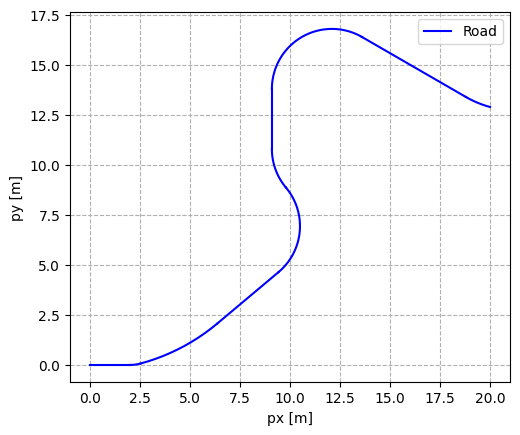

In [354]:
import numpy as np

# Instantiate a RoadEnv object
road_env = RoadEnv(epsilon_c=(1/200))

# Add some elements to build up a road
road_env.add_road_element_straight(2)
road_env.add_road_element_curved_by_angle(curvature=1/2, angle_in_degrees=15)
road_env.add_road_element_curved_by_angle(curvature=1/10, angle_in_degrees=25)
road_env.add_road_element_straight(4)
road_env.add_road_element_curved_by_angle(curvature=1/3, angle_in_degrees=90)
road_env.add_road_element_curved_by_angle(curvature=-1/3, angle_in_degrees=40)
road_env.add_road_element_straight(3)
road_env.add_road_element_curved_by_angle(curvature=-1/3, angle_in_degrees=120)
road_env.add_road_element_straight(6)
road_env.add_road_element_curved_by_angle(curvature=1/5, angle_in_degrees=15)

# Plot the road constructed so far
# > Open a figure and axis
fig, axs = plt.subplots(1, 1, sharex=True, sharey=False, gridspec_kw={"hspace": 0.2, "wspace": 0.4})
# > Call the plot function of the road environment
road_element_handles = road_env.render_road(axs)
# > Set the colour of all the line sections
for handle in road_element_handles: handle.set_color("blue")
# > Add labels and grid
axs.set_xlabel('px [m]')
axs.set_ylabel('py [m]')
axs.grid(visible=True, which="both", axis="both", linestyle='--')
# > Add a legend
road_element_handles[0].set_label("Road")
axs.legend(loc = 'upper right')
# Make the axes equal scale so that it looks more natural
axs.set_aspect('equal', adjustable='box')

## Find the closest point on the road

**Goal:** Given any coorindates in the world frame (i.e., the $(p_x,p_y)$ coordinates of the car), compute the coordinates on the road that are closest to that point.

A conceptually simple method to find the closet point on the road is to find the closest point for each road element, and then take the minimum of those. However, computing the closest point for a single road element can be tedious because we need to handle whether the closest point would be along the line or at one of its ends.

Instead, because the road is continous, and because we have restricted to straight and circular road elements, we can simplify the search. Specifically, for each road element, it is **only possible** for that road element to contain the closest point if the query point is in the region described by two hyperplanes, which in one hyperplane at each end of the road perpendicular to the road at the respective end.

Checking for the query point to be in a region described by two hyperplanes is a computationally easy check. Hence, we can significantly reduce the number of road element for which we need to compute the closet point for that element. Additionally, the region described by the hyperplane ensure that the closest point on a respective element lies along the element itself (and not at its ends). Hence, we can used this fact to simplify the computation of the closest point for each element that is a candidate.

Despite these simplifications, the function below still takes some effort to parse. Attempting to describe the checks in words:
* The hyperplane parameters were computed in the function above for derived properties of each road element.

  * The hyperlane normal is a unit vector that is tangent to the road at the start and end of the element respectively.
  * At the end the normal vector points in the direction of increasing progression, and at the start it points in the direction of decreasing progression.
  * Hence, the inclusion check is a "$Ax\leq b$" type check.

* For the road elements that are candidates for containing the closest point, the code then separates for straight elements and curved elements.
* For a straight element:

  * We construct a vector from the start of the element to the query point.
  * Then we compute the distance of the closest point by taking the dot product with a unit vector perpendicular to the road element.
  * Letting $\theta_i$ denote the angle of the straight road element relative to the world frame x-axis, a perpendicular unit vector is construct as:

  $$
  \begin{bmatrix} \cos(\theta_i + 0.5 \pi) \\ \sin(\theta_i + 0.5 \pi) \end{bmatrix}
  $$

  * From there, a bit of geometry completes the computation.

* For a curved road element:

  * We consrtuct a vector from the arc center of the road element to the query point.
  * Then we compute the length of this vector and subtract the radius of the road element.
  * Taking the absolute value of this give the distance to the closest point on that curved road element.
  * From there, a bit of geometry completes the computation.

For a given query point $(p_x,p_y)$, we describe the closet point on the road by:

* The euclidean distance between the query point and the closest point.
* The progression along the road of the closest point.
* The angle of the tangent to road at the closest point (realtive to world frame x-axis).
* The side of the road that the query point is on (when looking in the direction of increasing progression), i.e., left-hand or right-hand side.
* The index of the road element that contains the closest point.



In [355]:
class RoadEnv(RoadEnv):

    @classmethod
    def find_closest_point_to(self, px, py):
        """
        For a given quary point (i.e., (px,py)), this function computes the
        point on the road that is closest to that query point. Euclidean
        distance is the metric measuring and comparing distances.

        Parameters
        ----------
            px : float
                World frame x-axis coordinate of the query point (units: m).
            py : float
                World frame y-axis coordinate of the query point (units: m).

        Returns
        -------
            px_closest : float
                World frame x-axis coordinate of the closest point on the road (units: m).
            py_closest : float
                World frame y-axis coordinate of the closest point on the road (units: m).
            closest_distance : float
                Eucliedean distance between the query point and its closest point on the road (units: m).
            side_of_the_road_line : float
                The side of the road that the query point lies on (units: -1:=left-hand-side, 1:=right-hand-side)
            progress_at_closest_p : float
                The length of the whole road from its start until the closest point (units: m).
            road_angle_at_closest_p : float
                The tangent angles of the road at the closest point (units: radians).
            closest_element_idx : float
                The index of the road element that contains the closest point (units: index).
        """

        # Put the query point into a column vector
        p_query = np.array([[px],[py]],dtype=np.float32)
        # Compute the logic check for the start and end hyperplane
        start_check = np.less_equal( np.matmul(self.__start_hyperplane_A, p_query)[:,0] , self.__start_hyperplane_b )
        end_check   = np.less_equal( np.matmul(self.__end_hyperplane_A, p_query)[:,0]   , self.__end_hyperplane_b   )
        # Compute the combine check
        check = np.logical_and(start_check, end_check)
        # Get the indicies for the road elements to check
        idxs_to_check = np.where(check)[0]

        # Initialize the "closest distance" variable as this is used to keep
        # track of which point is the closest
        closest_distance = 10e10

        # Initialize the other variables that are to be returned
        px_closest = 0
        py_closest = 0
        side_of_the_road_line = 0
        progress_at_closest_p = 0
        road_angle_at_closest_p = 0
        closest_element_idx = 0

        for idx in idxs_to_check:
            if self.__isStraight[idx]:

                # Compute the closest distance to this road element
                this_vector_to_start = p_query[:,0] - self.__start_points[idx,:]
                this_perp_direction = np.array([np.cos(self.__start_angles[idx]+0.5*np.pi),np.sin(self.__start_angles[idx]+0.5*np.pi)])
                this_inner_product_perp = np.inner( this_vector_to_start , this_perp_direction )
                this_distance = abs( this_inner_product_perp )
                # Continue processing if this is the closest so far
                if (this_distance < closest_distance):
                    # Update the closest distance and idx
                    closest_distance = this_distance
                    closest_element_idx = idx
                    # Compute which side of the line it is on
                    side_of_the_road_line = (1.0) if (this_inner_product_perp >= 0) else  (-1.0)
                    # Compute the point to return
                    distance_from_start = np.inner( this_vector_to_start , self.__end_hyperplane_A[idx,:] )
                    px_closest = self.__start_points[idx,0] + distance_from_start * np.cos(self.__start_angles[idx])
                    py_closest = self.__start_points[idx,1] + distance_from_start * np.sin(self.__start_angles[idx])
                    # Compute the progress of the closest point
                    progress_at_closest_p = self.__l_total_at_end[idx] - self.__l[idx] + distance_from_start
                    # Set the road angle at this closest point
                    road_angle_at_closest_p = self.__start_angles[idx]
            else:
                # Compute the closest distance to this road element
                this_vector_to_arc_center = p_query[:,0] - self.__arc_centers[idx,:]
                this_dist_to_arc_center = np.linalg.norm(this_vector_to_arc_center)
                this_dist_to_arc = this_dist_to_arc_center - (1/abs(self.__c[idx]))
                this_distance = abs( this_dist_to_arc )
                # Continue processing if this is the closest so far
                if (this_distance < closest_distance):
                    # Update the closest distance and idx
                    closest_distance = this_distance
                    closest_element_idx = idx
                    # Compute which side of the line it is on
                    if (np.sign(self.__c[idx]) > 0):
                        side_of_the_road_line = (1.0) if (this_dist_to_arc < 0) else  (-1.0)
                    else:
                        side_of_the_road_line = (1.0) if (this_dist_to_arc > 0) else  (-1.0)
                    # Compute the point to return
                    p_closest = self.__arc_centers[idx,:] + this_vector_to_arc_center * 1/(this_dist_to_arc_center*abs(self.__c[idx]))
                    px_closest = p_closest[0]
                    py_closest = p_closest[1]
                    # Compute the progress of the closest point
                    angle_of_center_to_query_vector = np.arctan2( this_vector_to_arc_center[1], this_vector_to_arc_center[0] )
                    vector_arc_center_to_arc_start = self.__start_points[idx,:] - self.__arc_centers[idx,:]
                    angle_of_center_to_arc_start = np.arctan2( vector_arc_center_to_arc_start[1], vector_arc_center_to_arc_start[0] )
                    progress_at_closest_p = self.__l_total_at_end[idx] - self.__l[idx] + (1/abs(self.__c[idx])) * abs(angle_of_center_to_query_vector-angle_of_center_to_arc_start)
                    # Set the road angle at this closest point
                    proportion_progress = abs(angle_of_center_to_query_vector-angle_of_center_to_arc_start) / self.__phi[idx]
                    road_angle_at_closest_p = self.__start_angles[idx] + proportion_progress * (self.__end_angles[idx]-self.__start_angles[idx])

        # Return the results
        return px_closest, py_closest, closest_distance, side_of_the_road_line, progress_at_closest_p, road_angle_at_closest_p, closest_element_idx


We test the "find closest point" function by generating random points and visualizing the result of the function above for each point. Specifically, we:

* Plot a line from each query point to the point on the road that is computed to be its closest point.
* Label the line with the progresion distance along the road at the closest point.

Results for each queriy point
( progress , road angle ) = ( 22.1 , 81.7 )
( progress , road angle ) = ( 40.4 , 0.0 )
( progress , road angle ) = ( 30.2 , -30.0 )
( progress , road angle ) = ( 14.9 , 97.7 )
( progress , road angle ) = ( 35.6 , -23.2 )
( progress , road angle ) = ( 9.4 , 40.0 )
( progress , road angle ) = ( 7.4 , 37.4 )
( progress , road angle ) = ( 6.4 , 31.5 )
( progress , road angle ) = ( 17.5 , 113.2 )
( progress , road angle ) = ( 19.4 , 90.0 )
( progress , road angle ) = ( 8.9 , 40.0 )
( progress , road angle ) = ( 9.8 , 40.0 )
( progress , road angle ) = ( 38.8 , 0.0 )
( progress , road angle ) = ( 13.4 , 68.4 )
( progress , road angle ) = ( 18.7 , 90.1 )
( progress , road angle ) = ( 18.3 , 98.4 )
( progress , road angle ) = ( 14.7 , 93.0 )
( progress , road angle ) = ( 38.3 , 0.0 )
( progress , road angle ) = ( 38.1 , 0.0 )
( progress , road angle ) = ( 9.3 , 40.0 )
To assist with checking the text labels on the figure are approximately correct:
l_total_at_end =

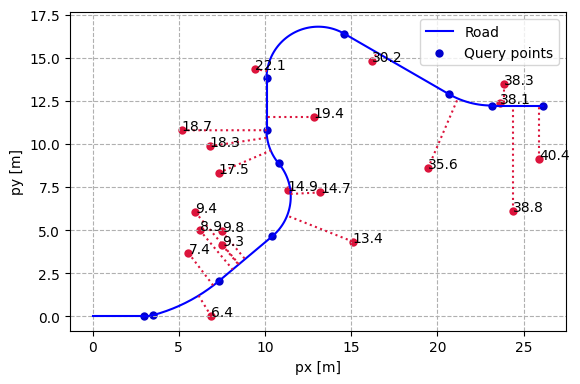

In [356]:
# Instantiate a RoadEnv object
road_env = RoadEnv(epsilon_c=(1/200))

# Add some elements to build up a road
road_env.add_road_element_straight(3)
road_env.add_road_element_curved_by_angle(curvature=1/2, angle_in_degrees=15)
road_env.add_road_element_curved_by_angle(curvature=1/10, angle_in_degrees=25)
road_env.add_road_element_straight(4)
road_env.add_road_element_curved_by_angle(curvature=1/3, angle_in_degrees=90)
road_env.add_road_element_curved_by_angle(curvature=-1/3, angle_in_degrees=40)
road_env.add_road_element_straight(3)
road_env.add_road_element_curved_by_angle(curvature=-1/3, angle_in_degrees=120)
road_env.add_road_element_straight(7)
road_env.add_road_element_curved_by_angle(curvature=1/5, angle_in_degrees=30)
road_env.add_road_element_straight(3)

# Plot the road constructed so far
# > Open a figure and axis
fig, axs = plt.subplots(1, 1, sharex=True, sharey=False, gridspec_kw={"hspace": 0.2, "wspace": 0.4})
# > Call the plot function of the road environment
road_element_handles = road_env.render_road(axs)
# > Set the colour of all the line sections
for handle in road_element_handles: handle.set_color("blue")
# > Add labels and grid
axs.set_xlabel('px [m]')
axs.set_ylabel('py [m]')
axs.grid(visible=True, which="both", axis="both", linestyle='--')
# > Add a label for the legend
road_element_handles[0].set_label("Road")

# Set the aspect ratio so that box axes are equal scale
axs.set_aspect('equal', adjustable='box')

# Plot the end points of each road element so that it is easier to visually check the results
end_points = road_env.get_end_points()
road_knots_handle = axs.scatter(end_points[:,0],end_points[:,1], linewidth=0, marker="o", color = "mediumblue")
# > Add a label for the legend
road_knots_handle.set_label("Road knots")

# Generate some random query points
min_xy = np.min(end_points, axis=0)
max_xy = np.max(end_points, axis=0)
num_query_points = 20
px_queries = np.random.uniform(low=min_xy[0], high=max_xy[0], size=(num_query_points,))
py_queries = np.random.uniform(low=min_xy[1], high=max_xy[1], size=(num_query_points,))

# Or hard-code a few query points for checking edge cases
#px_queries = np.array([19.2])
#py_queries = np.array([14.0])
#num_query_points = len(px_queries)

# Plot the query points
query_points_handle = axs.scatter(px_queries,py_queries, linewidth=0, marker="o", color = "crimson")
# > Add a label for the legend
road_knots_handle.set_label("Query points")

# Display the legend
axs.legend(loc = 'upper right')

print("Results for each queriy point")

# Iterate over the query points
for query_idx in np.arange(0,num_query_points):
    # Extract this query point
    px_query = px_queries[query_idx]
    py_query = py_queries[query_idx]

    # Call the find closest point function
    px_closest, py_closest, closest_distance, side_of_the_road_line, progress_at_closest_p, road_angle_at_closest_p, closest_element_idx = road_env.find_closest_point_to(px=px_query, py=py_query)

    # Plot the line between the query point and its closest point computed
    axs.plot([px_query,px_closest],[py_query,py_closest], linestyle=":", color="crimson")

    # Annotate the line with the progress value computed
    axs.annotate("{:.1f}".format(progress_at_closest_p), xy=(px_query, py_query))

    # Display the progress and road angle
    print("( progress , road angle ) = ( " + "{:.1f}".format(progress_at_closest_p) + " , " + "{:.1f}".format(road_angle_at_closest_p*(180/np.pi)) + " )" )

print("To assist with checking the text labels on the figure are approximately correct:")
print("l_total_at_end = " + str(road_env.get_l_total_at_end()))


## Compute coordinates of given road progression (in world frame and in body frame)

The context of this road environment is that the road defines the path that an autonomous vehicle must follow, with the primary feedback being detection on the road line relative to the position of the vehicle. Hence for a given position of the vehicle, we need to:

1. Compute a sequence of upcoming points on the road that might be visible to the vehicle.
2. Transform those points into camera pixel coordinates (or other sensor coordinate) that the vehicle would actaully detect as feedback.

This section deals with point (1) and the next section deals with point (2).

The following class function takes as input an array of progression values, and returns the world frame coordinates for each, as well as the road angle at each.

In [357]:
class RoadEnv(RoadEnv):

    @classmethod
    def convert_progression_to_coordinates(self, progression_queries):
        """
        Computes the world-frame coordinates of points along the road where the length of
        whole road (i.e., progression from the start of the road) equal to the query value.

        Parameters
        ----------
            progressing query : numpy array
                Value of road progression for which the world-frame coordinates. should be computed (units: m).

        Returns
        -------
            p_coords : numpy array
                The world frame coordinates for each progression query,
                2-dimensional array with size = number of queries -by- 2,
                (units: m).
            p_angles : numpy array
                The tangent angle of the road for each progression query,
                1-dimensional array with length = number of queries,
                (units: radians).
        """
        # Get the number of progression query values
        num_queries = len(progression_queries)

        # Initialise arrays for the results to be returned
        p_coords = np.zeros((num_queries,2), dtype=np.float32)
        p_angles = np.zeros((num_queries,), dtype=np.float32)

        # Compute the index of the road element for each progression value
        road_idxs = np.searchsorted( self.__l_total_at_end , progression_queries, side="left", sorter=None)

        # Iterate through the progression values
        for i_prog in np.arange(0,num_queries):
            # Get the value of progression
            this_prog = progression_queries[i_prog]

            # Get the road element index
            this_road_idx = road_idxs[i_prog]

            # Check if the progression is beyond the end of the road
            if (this_road_idx == len(self.__l_total_at_end) ):
                p_coords[i_prog,0] = np.nan
                p_coords[i_prog,1] = np.nan
                p_angles[i_prog]   = np.nan

            # Also check if the progression is before the start of the road
            elif (this_prog < 0):
                p_coords[i_prog,0] = np.nan
                p_coords[i_prog,1] = np.nan
                p_angles[i_prog]   = np.nan

            # Otherwise:
            else:
                # Compute the extra progression from the start of this road element
                this_prog_from_start_of_road_element = this_prog - (self.__l_total_at_end[this_road_idx]-self.__l[this_road_idx])

                # Switch depending on the type of road element
                if (self.__isStraight[this_road_idx]):
                    # Get the angle
                    this_angle = self.__start_angles[this_road_idx]
                    # Compute the coords
                    p_coords[i_prog,0] = self.__start_points[this_road_idx,0] + this_prog_from_start_of_road_element * np.cos(this_angle)
                    p_coords[i_prog,1] = self.__start_points[this_road_idx,1] + this_prog_from_start_of_road_element * np.sin(this_angle)
                    # Put in the angle
                    p_angles[i_prog] = this_angle

                else:
                    # Compute the angular range from the start to the progress point
                    this_prog_phi = (this_prog_from_start_of_road_element/self.__l[this_road_idx]) * self.__phi[this_road_idx]
                    # Compute the chord length from the start to the progress point
                    this_chord_length = 2.0 * (1/abs(self.__c[this_road_idx])) * np.sin(0.5*this_prog_phi)
                    # Compute the angle of the chord
                    this_chord_angle = self.__start_angles[this_road_idx] + np.sign(self.__c[this_road_idx]) * 0.5 * this_prog_phi
                    # Compute the coords
                    p_coords[i_prog,0] = self.__start_points[this_road_idx,0] + this_chord_length * np.cos(this_chord_angle)
                    p_coords[i_prog,1] = self.__start_points[this_road_idx,1] + this_chord_length * np.sin(this_chord_angle)
                    # Compute the angle
                    p_angles[i_prog] = this_chord_angle + np.sign(self.__c[this_road_idx]) * 0.5 * this_prog_phi

        # Return the coordinates and angles
        return p_coords, p_angles




Recal that the overall goal is to compute the road coordinates as observed by the senors on a vehcile. Hence we add a convenience function to the `RoadEnv` class for transforming an array coordinates by a specified transform. For the 2D setting that we are considering, a tranform is specified by:

* The angle of the frame to trasnform to relative to the current frame, i.e., the angle of the vehcile relative to the world frame x-axis, i.e., a **rotation** operation.
* The origin point of the frame to transform expressed in coordinates of the current frame, i.e., the position of the vehicle in world frame coordinate, i.e., a **translation** operation.

In [358]:
class RoadEnv(RoadEnv):

    @staticmethod
    def transform_points_2d( p , px_translate, py_translate, theta_rotate, p_translate_is_in_starting_frame=True):
        """
        Transform 2D points from one frame to another. The order of translate
        and rotate depdned on which frame the translation vector is given in.

        If the transalation vector is expressed in the coordinates of the
        original frame (i.e., the untransformed frame), then the steps are:
            1. Translate by (px_translate,py_translate).
            2. Rotate by theta_rotate.

        If the transalation vector is expressed in the coordinates of the
        destination frame (i.e., the transformed frame), then the steps are:
            1. Rotate by theta_rotate.
            2. Translate by (px_translate,py_translate).

        Parameters
        ----------
            p : numpy array
                The point to be transformed, 2-dimensional array with:
                size = number of points to transform -by- 2,
                (units: m).
            px_translate : float
                X-axis length of the translation vector (units: m).
            py_translate : float
                Y-axis length of the translation vector (units: m).
            theta_rotate : float
                The angle of rotation between the original and destination
                frames (units: radians).
            p_translate_is_in_starting_frame : boolean
                A flag for indicating the frame of the translation vector:
                True := translation vector is in the original frame.
                True := translation vector is in the destination frame.

        Returns
        -------
            p_transformed : numpy array
                The coordinates for each point in "p" expressed in coordinates
                of the destination frame, 2-dimensional array with:
                size = number of points to transform -by- 2,
                (units: m).
        """
        # Construct the rotation matrix
        R_mat = np.array([[np.cos(theta_rotate),np.sin(theta_rotate)],[-np.sin(theta_rotate),np.cos(theta_rotate)]])
        if (p_translate_is_in_starting_frame):
            # Translate all the point
            p_translated = np.subtract( p , np.array([[px_translate,py_translate]]) )
            # Rotate all the points
            p_transformed = np.matmul( R_mat , np.transpose(p_translated) )
        else:
            # Rotate all the points
            p_rotated = np.matmul( R_mat , np.transpose(p) )
            # Translate all the point
            p_transformed = np.subtract( p_rotated , np.array([[px_translate],[py_translate]]) )

        # Return the result
        return np.transpose(p_transformed)


We test this function by asking for the points and angle of regularly spaced progression queries along the whole road:

1. First, we need to construct and plot the road again.
2. Then we generate progression points and call the conversion function for testing its accuracy.

Last few p_coords = [[23.782879 12.221176]
 [24.875055 12.221176]
 [25.967232 12.221176]
 [      nan       nan]]


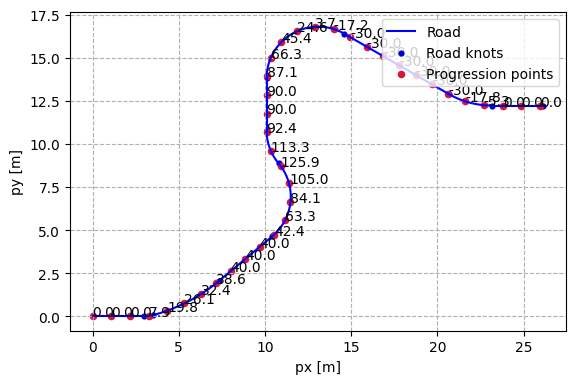

In [359]:
# ===========================
# CONSTRUCT AND PLOT THE ROAD
# ===========================

# Instantiate a RoadEnv object
road_env = RoadEnv(epsilon_c=(1/200))

# Add some elements to build up a road
road_env.add_road_element_straight(3)
road_env.add_road_element_curved_by_angle(curvature=1/2, angle_in_degrees=15)
road_env.add_road_element_curved_by_angle(curvature=1/10, angle_in_degrees=25)
road_env.add_road_element_straight(4)
road_env.add_road_element_curved_by_angle(curvature=1/3, angle_in_degrees=90)
road_env.add_road_element_curved_by_angle(curvature=-1/3, angle_in_degrees=40)
road_env.add_road_element_straight(3)
road_env.add_road_element_curved_by_angle(curvature=-1/3, angle_in_degrees=120)
road_env.add_road_element_straight(7)
road_env.add_road_element_curved_by_angle(curvature=1/5, angle_in_degrees=30)
road_env.add_road_element_straight(3)

# Plot the road constructed so far
# > Open a figure and axis
fig, axs = plt.subplots(1, 1, sharex=True, sharey=False, gridspec_kw={"hspace": 0.2, "wspace": 0.4})
# > Call the plot function of the road environment
road_element_handles = road_env.render_road(axs)
# > Set the colour of all the line sections
for handle in road_element_handles: handle.set_color("blue")
# > Add labels and grid
axs.set_xlabel('px [m]')
axs.set_ylabel('py [m]')
axs.grid(visible=True, which="both", axis="both", linestyle='--')
# > Add a label for the legend
road_element_handles[0].set_label("Road")

# Set the aspect ratio so that box axes are equal scale
axs.set_aspect('equal', adjustable='box')

# Plot the end points of each road element so that it is easier to visually check the results
end_points = road_env.get_end_points()
road_knots_handle = axs.scatter(end_points[:,0],end_points[:,1], linewidth=0, marker="o", color="mediumblue", s=20)
# > Add a label for the legend
road_knots_handle.set_label("Road knots")

# ==================================
# TEST THE PROGESSION QUERY FUNCTION
# ==================================

# Construct the progression queries
l_total_at_end = road_env.get_l_total_at_end()
prog_queries = np.linspace(start=0, stop=l_total_at_end[-1]+2, num=40)

# Call the class function to convert to coordinates and angles
p_coords, p_angles = road_env.convert_progression_to_coordinates(prog_queries)

# Display the last few to check they were set to nan
print("Last few p_coords = " + str(p_coords[-5:-1,:]))

# Plot the coordinates
road_knots_handle = axs.scatter(p_coords[:,0],p_coords[:,1], linewidth=0, marker="o", color = "crimson", s=30)
# > Add a label for the legend
road_knots_handle.set_label("Progression points")

# Display the legend
axs.legend(loc = 'upper right')

# Annotate each point with its angle computed
for i_query in np.arange(0,len(prog_queries)):
    axs.annotate("{:.1f}".format(p_angles[i_query]*(180/np.pi)), xy=(p_coords[i_query,0], p_coords[i_query,1]))



Now test the tranformation of the progression points into the frame of a car

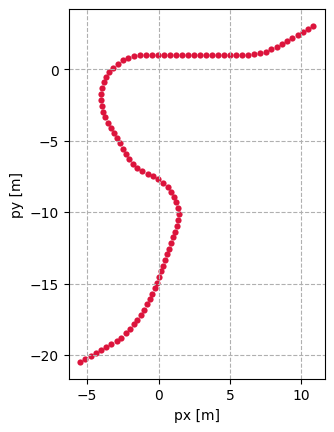

In [360]:
# Construct the progression queries
l_total_at_end = road_env.get_l_total_at_end()
prog_queries = np.linspace(start=0, stop=l_total_at_end[-1]+1, num=100)

# Call the class function to convert to coordinates and angles
p_coords, p_angles = road_env.convert_progression_to_coordinates(prog_queries)

# Hardcode a test point
#p_coords = np.array([[0,0],[0,1],[1,0]], dtype=np.float32)

# Specify the car location
px_car = 15
py_car = 15
theta_car = -30 * (np.pi/180)

# Transform the points
p_transformed = road_env.transform_points_2d( p_coords , px_car, py_car, theta_car)

# Plot the tranformed points
# > Open a figure and axis
fig, axs = plt.subplots(1, 1, sharex=True, sharey=False, gridspec_kw={"hspace": 0.2, "wspace": 0.4})
# > Plot the point
p_transformed_handle = axs.scatter(p_transformed[:,0],p_transformed[:,1], linewidth=0, marker="o", color="crimson", s=20)
# > Add labels and grid
axs.set_xlabel('px [m]')
axs.set_ylabel('py [m]')
axs.grid(visible=True, which="both", axis="both", linestyle='--')
# > Add a label for the legend
#road_element_handles[0].set_label("Road")

# Set the aspect ratio so that box axes are equal scale
axs.set_aspect('equal', adjustable='box')


## Compute camera-frame pixel-coorindates

**GOAL:** Simulating the line-detection data that is computed by a camera mounted on the car. Hence, the goal is to transform points on the road (which we have from the functions above) it the camera pixels that would be activated by light eminating from those points.

In order to simulate such line-detection data, we need:

* The persepctive model of how a camera observes the world.

* Details of the camera as necessary for the model in the previous point, specifically:

  * **Resolution** of the camera, for example, 1920x1080 pixels.
  * The so-called **intrinsic paramters** of the camera, which are focal length, pixel size, and optical center. These are described further below.
  * A **tranformation** describing where the camera is mount on the car relative to the origin of the car, which are the so-called **extrinsic parameters**.


An in depth model of a camera is beyond the scope of this tutorial, you can review the many resources out there, with the [OpenCV tutorial on homography](https://docs.opencv.org/4.x/d9/dab/tutorial_homography.html) being a great starting point. Instead, we jump directly to the key equation that is given in many resources:

$$
\lambda \, \begin{bmatrix} u \\ v \\ 1 \end{bmatrix}
  \,=\,
  \underbrace{
    \begin{bmatrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{bmatrix}
  }_{\text{intrinsic params.}}
  \,
  \underbrace{
    \begin{bmatrix} ^{(\text{C})}R_{(\text{B})} &|& T_{(\text{C})\rightarrow(\text{B})}^{(\text{C})} \end{bmatrix}
  }_{\text{extrinsic params.}}
  \,
  \begin{bmatrix} p_x^{(\text{B})} \\ p_y^{(\text{B})} \\ p_z^{(\text{B})} \\ 1 \end{bmatrix}
$$

where each of the symbols is defined as follows:

* $\lambda \in\mathbb{R}$ : is an arbitary scalig factor that reflects the fact that light eminating all body frame coordinates along the same ray impact the exact same pixel on the camera.
* $f_x$ : The focal length of the camera lens (units: m) multiplied by the pixel density (units: pixels/m) in the x-direction of the camera frame, hence, overall this is the focal length in units of pixels in the x-direction.
* $f_y$ : same as $f_x$ but for the y-direction of the camera frame, hence, overal this is the focal length in units of pixels in the y-direction.
* $c_x$ : the camera-frame x-direction coorindate of optical center of the camera lens in pixels, relative to the origin of the camera's pixel array.
* $c_y$ : the same as $c_x$ but for the camera-frame y-direction coordinate.
* $^{(\text{C})}R_{(\text{B})}$ : The rotation matrix from the body frame of the robot to the camera frame.
* $T_{(\text{C})\rightarrow(\text{B})}^{(\text{C})}$ : The translation vector point from the camera frame origin to the body frame origin, expressed in camera frame coordinates.
* $p_x^{(\text{B})}$, $p_y^{(\text{B})}$, $p_z^{(\text{B})}$ : any point in space expressed in the body frame coordinates. For modelling a robot moving on a 2D horizontal plane, $p_z^{(\text{B})}=0$ for all points on the ground plane.
* $(u,v)$ : is the camera-frame pixel coordinate on the pixel array (x and y directions respectively) that receives the light eminating from the body frame point.

It is often easier to express the vector from the camera frame origin to the body frame origin in the body frame coordinates, i.e, $T_{(\text{C})\rightarrow(\text{B})}^{(\text{B})}$. For example, if the camera is directly above the middle of the front axel by some distance, then we would have:

$$
T_{(\text{C})\rightarrow(\text{B})}^{(\text{B})} \,=\,
  \begin{bmatrix} 0 \\ 0 \\ - h_{\text{camera}} \end{bmatrix}
$$

where $h_{\text{camera}}$ is the distance from the ground plane up to the optical center of the camera. Hence we can adjust the equation above to use this term directly:

$$
\lambda \, \begin{bmatrix} u \\ v \\ 1 \end{bmatrix}
  \,=\,
  \underbrace{
    \begin{bmatrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{bmatrix}
  }_{\text{intrinsic params.}}
  \,
  ^{(\text{C})}R_{(\text{B})}
  \,
  \left(\,
    \begin{bmatrix} p_x^{(\text{B})} \\ p_y^{(\text{B})} \\ p_z^{(\text{B})} \end{bmatrix}
    \,+\,
    T_{(\text{C})\rightarrow(\text{B})}^{(\text{B})}
  \,\right)
$$

Furthermore, if the camera is facing directly forwards, i.e., looking in the x-direction of the body frame and with a tilt down towards the ground of $\alpha_{\text{camera}}$ radians from the horizontal, then we can easily construct the rotation matrix $^{(\text{C})}R_{(\text{B})}$.

The frame convention for a camera is that the z-axis points directly out of the lens, the y-axis points downwards, and the x-axis is such that the frame follow the right-hand rule. Hence, starting from the body frame:

* We first align with the camera frame x-axis by rotating $-90$ degrees about the body frame z-axis, i.e.,

$$
\begin{bmatrix} 0 & -1 & 0 \\ 1 & 0 & 0 \\ 0 & 0 & 1 \end{bmatrix}
$$

* We then align with the camera frame z-axes by rotating $-(0.5\pi+\alpha_{\text{camera}})$ about the camera frame x-axis, i.e.,

$$
\begin{bmatrix} 1 & 0 & 0 \\ 0 & \cos(-(0.5\pi+\alpha_{\text{camera}})) & \sin(-(0.5\pi+\alpha_{\text{camera}})) \\ 0 & -\sin(-(0.5\pi+\alpha_{\text{camera}})) & \cos(-(0.5\pi+\alpha_{\text{camera}})) \end{bmatrix}
$$

* Multiplying these two together results in the required rotation martrix, i.e.:

$$
\begin{aligned}
  ^{(\text{C})}R_{(\text{B})}
    \,=\,&
    \begin{bmatrix} 1 & 0 & 0 \\ 0 & \cos(-(0.5\pi+\alpha_{\text{camera}})) & \sin(-(0.5\pi+\alpha_{\text{camera}})) \\ 0 & -\sin(-(0.5\pi+\alpha_{\text{camera}})) & \cos(-(0.5\pi+\alpha_{\text{camera}})) \end{bmatrix}
    \,\,
    \begin{bmatrix} 0 & -1 & 0 \\ 1 & 0 & 0 \\ 0 & 0 & 1 \end{bmatrix}
    \\
    \,=\,&
    \begin{bmatrix}
    0 & -1 & 0
    \\
    \cos(-(0.5\pi+\alpha_{\text{camera}})) & 0 & \sin(-(0.5\pi+\alpha_{\text{camera}}))
    \\
    \sin(-(0.5\pi+\alpha_{\text{camera}})) & 0 & \cos(-(0.5\pi+\alpha_{\text{camera}}))
    \end{bmatrix}
\end{aligned}
$$

"All" that remains is to apply the key equation. To do so, we first observe that the "extrinsic portion" is simply expressing the body frame point in camera frame coordinates, i.e.,

$$
  \begin{bmatrix} p_x^{(\text{C})} \\ p_y^{(\text{C})} \\ p_z^{(\text{C})} \end{bmatrix}
  \,=\,
  ^{(\text{C})}R_{(\text{B})}
  \,
  \left(\,
    \begin{bmatrix} p_x^{(\text{B})} \\ p_y^{(\text{B})} \\ p_z^{(\text{B})} \end{bmatrix}
    \,+\,
    T_{(\text{C})\rightarrow(\text{B})}^{(\text{B})}
  \,\right)
$$

Hence the equation to apply for computing the camera pixel coorindates $(u,v)$ is:

$$
\lambda \, \begin{bmatrix} u \\ v \\ 1 \end{bmatrix}
  \,=\,
  \underbrace{
    \begin{bmatrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{bmatrix}
  }_{\text{intrinsic params.}}
  \,
  \begin{bmatrix} p_x^{(\text{C})} \\ p_y^{(\text{C})} \\ p_z^{(\text{C})} \end{bmatrix}
$$

We see that this equation requires that $\lambda = p_z^{(\text{C})}$. Eliminating this equation, we hence get that:

$$
\begin{bmatrix} u \\ v \end{bmatrix}
  \,=\,
  \underbrace{
    \begin{bmatrix} f_x & 0 & c_x \\ 0 & f_y & c_y \end{bmatrix}
  }_{\text{intrinsic params.}}
  \,
  \begin{bmatrix} \frac{p_x^{(\text{C})}}{p_z^{(\text{C})}} \\ \frac{p_y^{(\text{C})}}{p_z^{(\text{C})}} \\ 1 \end{bmatrix}
$$

And multiply this out of the sake of completeness, we get:

$$
\begin{aligned}
  u \,=\,& f_x \, \frac{p_x^{(\text{C})}}{p_z^{(\text{C})}} \,+\, c_x
  \\
  v \,=\,& f_y \, \frac{p_y^{(\text{C})}}{p_z^{(\text{C})}} \,+\, c_y
\end{aligned}
$$

**In summary**, given a point in the body frame:

1. We compute the vector:

$$
\begin{bmatrix} \lambda \, u \\ \lambda \, v \\ \lambda \end{bmatrix}
  \,=\,
  \underbrace{
    \begin{bmatrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{bmatrix}
  }_{\text{intrinsic params.}}
  \,
  ^{(\text{C})}R_{(\text{B})}
  \,
  \left(\,
    \begin{bmatrix} p_x^{(\text{B})} \\ p_y^{(\text{B})} \\ p_z^{(\text{B})} \end{bmatrix}
    \,+\,
    T_{(\text{C})\rightarrow(\text{B})}^{(\text{B})}
  \,\right)
$$

2. We divide the first two element of this result by the third element to get $(u,v)$ pixel coordinates on the pixel array.

3. If we have multiple points in the body frame to transform, then we just stack them side-by-side.

We now put this tranformation into a static class method.


In [361]:
class RoadEnv(RoadEnv):

    @staticmethod
    def transform_to_camera_pixel( p , R_BtoC, T_CtoB_inB, intrinsic_matrix):
        """
        Transform 3-dimensional coordinates expressed in the body frame of the
        robot / car, to 2-dimensional pixel coordinates of the camera that is
        observing the world environment from its fixed mounting location on the
        robot / car.

        Parameters
        ----------
            p : numpy array
                The points to be transformed, 2-dimensional array with:
                size = number of points to transform -by- 3,
                (units: m).
            R_BtoC : numpy array
                The rotation matrix from the body frame to the camera frame,
                2-dimensional array with: size = 3 -by- 3, (units: unitless).
            T_CtoB_inB : numpy array
                Translation vector that points from the origin on the camera
                frame (i.e., the center point of the camer lens), to the origin
                of the body frame, 2-dimensional array with: size = 3 -by- 1,
                (units: m).
            intrinsic_matrix : numpy array
                The matrix that contain the intrinsic paramters of the camera
                in the "usual" format of: [ [fx 0 cx] , [0 fy cy] , [0 0 1] ],
                2-dimensional array with: size = 3 -by- 3, (units: pixels/m).

        Returns
        -------
            uv : numpy array
                The coordinates for each point in "p" expressed in coordinates
                of the camera pixels, "u" is the pixel location in the
                camera-frame x-direction, and "v" in the camera-frame
                y-direction, 2-dimensional array with:
                size = number of points to transform -by- 2,
                (units: pixels).
        """
        # Convert all the points to the scaled pixel coordinates
        uv_scaled = np.matmul( intrinsic_matrix , np.matmul( R_BtoC , np.transpose(p) + T_CtoB_inB ) )

        # Disregard points that are behind (or too close to) the camera
        uv_lambda = uv_scaled[2:3,:]
        uv_lambda[uv_lambda<0.01] = np.nan

        uv = np.divide( uv_scaled[0:2,:] , uv_lambda )

        # Return the result
        return np.transpose(uv)

Before testing this out, we add a convenience function that compute the camera image for a vehicle location are a given position and angle. This brings together a number of the previous steps into one function that it most useful to scripts that utilize this `RoadEnv` class.

In [362]:
class RoadEnv(RoadEnv):

    def line_detection_pixels_for_given_pose(self, px, py, theta, R_BtoC, T_CtoB_inB, intrinsic_matrix, resolution_width, resolution_height ):
        """
        Utilizes the other functions in this class to minic the output of a
        line dectection algorithm running on a camera image captured by the
        robot / car. The major steps of this function are:
        1. Find the closest point on the road for the given query point (px,py)
        2. Generate a sequence of progression values forwards and backwards from
           that closest point.
        3. Get the world-frame coordinates for all the progression values.
        4. Transform those world-frame coordinates into pixel coordinates.

        Parameters
        ----------
            px : float
                World-frame x-axis coordinate of the robot / car (units: m).
            py : float
                World-frame y-axis coordinate of the robot / car (units: m).
            theta : float
                Heading angle of the robot / car relative to the world-frame
                x-axis (units: radians).
            R_BtoC : numpy array
                The rotation matrix from the body frame to the camera frame,
                2-dimensional array with: size = 3 -by- 3, (units: unitless).
            T_CtoB_inB : numpy array
                Translation vector that points from the origin on the camera
                frame (i.e., the center point of the camer lens), to the origin
                of the body frame, 2-dimensional array with: size = 3 -by- 1,
                (units: m).
            intrinsic_matrix : numpy array
                The matrix that contain the intrinsic paramters of the camera
                in the "usual" format of: [ [fx 0 cx] , [0 fy cy] , [0 0 1] ],
                2-dimensional array with: size = 3 -by- 3, (units: pixels/m).
            resolution_width : integer
                The pixel size of the camera's pixel array in the camera-frame
                x-axis direction
            resolution_height : integer
                The pixel size of the camera's pixel array in the camera-frame
                y-axis direction

        Returns
        -------
            uv_coords : numpy array
                The coordinates for each line dectection point expressed in
                coordinates of the camera pixels, "u" is the pixel location in
                the camera-frame x-direction, and "v" in the camera-frame
                y-direction, 2-dimensional array with:
                size = number of points detected within the camera's pixel array -by- 2,
                (units: pixels).
            info_dict : dictionary
                Containing additional detail for each of the points in the
                "uv_coords" array.
        """
        # Compute the closest point on the road
        px_closest, py_closest, closest_distance, side_of_the_road_line, progress_at_closest_p, road_angle_at_closest_p, closest_element_idx = self.find_closest_point_to(px=px, py=py)

        # Construct an array of progression for a sufficiently long look ahead
        l_total_at_end = self.get_l_total_at_end()
        #prog_queries = np.arange(start=max(0,progress_at_closest_p-2), stop=progress_at_closest_p+50, step=0.5, dtype=np.float32)
        #prog_queries = np.logspace(start=np.log10(max(0.01,progress_at_closest_p-2)), stop=np.log10(progress_at_closest_p+50), num=100, base=10, dtype=np.float32)
        prog_queries = np.concatenate((
            np.arange(start=max(0,progress_at_closest_p-2), stop=progress_at_closest_p+2, step=0.1, dtype=np.float32),
            np.arange(start=progress_at_closest_p+2, stop=progress_at_closest_p+7, step=0.2, dtype=np.float32),
            np.arange(start=progress_at_closest_p+7, stop=progress_at_closest_p+20, step=0.5, dtype=np.float32),
            np.arange(start=progress_at_closest_p+20, stop=progress_at_closest_p+30, step=1.0, dtype=np.float32),
            np.arange(start=progress_at_closest_p+30, stop=progress_at_closest_p+50, step=2.0, dtype=np.float32),
        ))


        # Convert the progession array to coordinates and angles along the upxoming section of road
        p_coords, p_angles = self.convert_progression_to_coordinates(prog_queries)

        # Transform the points into the body frame of the given pose
        p_in_body_frame = road_env.transform_points_2d( p_coords , px, py, theta)

        # Add the body-frame z-coordinates to be zero, i.e., the 2D ground plane
        p_3D_in_body_frame = np.hstack( (p_in_body_frame , np.zeros((p_in_body_frame.shape[0],1),dtype=np.float32) ))

        # Compute the pixel cordinates
        uv_coords_all = self.transform_to_camera_pixel( p_3D_in_body_frame , R_BtoC, T_CtoB_inB, intrinsic_matrix)

        # Remove coordinates that are not in the image array
        pixel_buffer = 0
        valid_uv_indices = np.logical_and( np.logical_and(uv_coords_all[:,0]>=(0-pixel_buffer), uv_coords_all[:,0]<=(resolution_width+pixel_buffer)) , np.logical_and(uv_coords_all[:,1]>=(0-pixel_buffer), uv_coords_all[:,1]<=(resolution_height+pixel_buffer)) )
        uv_coords = uv_coords_all[valid_uv_indices,:]

        p_visible_in_body_frame = p_in_body_frame[valid_uv_indices,:]

        progression_of_each_coord = prog_queries[valid_uv_indices]

        # Create an info dictionary with all the extra details
        info_dict = {
            "px" : px,
            "py" : py,
            "px_closest" : px_closest,
            "py_closest" : py_closest,
            "closest_distance" : closest_distance,
            "side_of_the_road_line" : side_of_the_road_line,
            "progress_at_closest_p" : progress_at_closest_p,
            "road_angle_at_closest_p" : road_angle_at_closest_p,
            "closest_element_idx" : closest_element_idx,
            "p_visible_in_body_frame" : p_visible_in_body_frame,
            "progression_of_each_coord" : progression_of_each_coord,
        }

        # Return the pixel coordinates and the info dictionary
        return uv_coords, info_dict

We now test this out for a realistic scenario


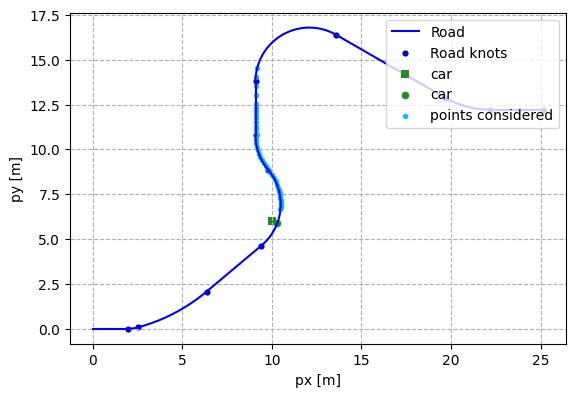

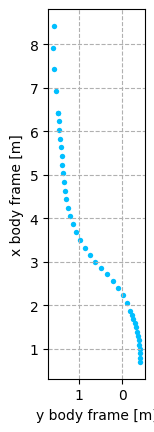

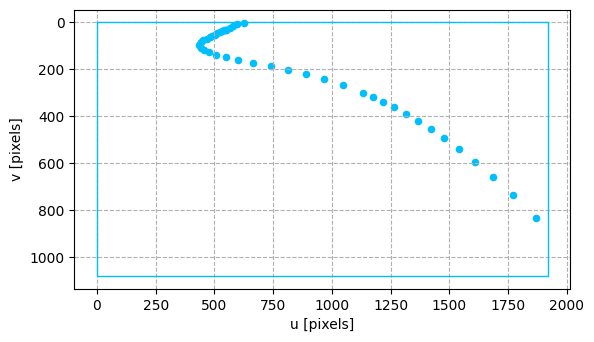

In [363]:
# ===========================
# CONSTRUCT AND PLOT THE ROAD
# ===========================

# Instantiate a RoadEnv object
road_env = RoadEnv(epsilon_c=(1/200))

# Add some elements to build up a road
road_env.add_road_element_straight(2)
road_env.add_road_element_curved_by_angle(curvature=1/2, angle_in_degrees=15)
road_env.add_road_element_curved_by_angle(curvature=1/10, angle_in_degrees=25)
road_env.add_road_element_straight(4)
road_env.add_road_element_curved_by_angle(curvature=1/3, angle_in_degrees=90)
road_env.add_road_element_curved_by_angle(curvature=-1/3, angle_in_degrees=40)
road_env.add_road_element_straight(3)
road_env.add_road_element_curved_by_angle(curvature=-1/3, angle_in_degrees=120)
road_env.add_road_element_straight(7)
road_env.add_road_element_curved_by_angle(curvature=1/5, angle_in_degrees=30)
road_env.add_road_element_straight(3)

# Plot the road constructed so far
# > Open a figure and axis
fig, axs = plt.subplots(1, 1, sharex=True, sharey=False, gridspec_kw={"hspace": 0.2, "wspace": 0.4})
# > Call the plot function of the road environment
road_element_handles = road_env.render_road(axs)
# > Set the colour of all the line sections
for handle in road_element_handles: handle.set_color("blue")
# > Add labels and grid
axs.set_xlabel('px [m]')
axs.set_ylabel('py [m]')
axs.grid(visible=True, which="both", axis="both", linestyle='--')
# > Add a label for the legend
road_element_handles[0].set_label("Road")

# Set the aspect ratio so that box axes are equal scale
axs.set_aspect('equal', adjustable='box')

# Plot the end points of each road element so that it is easier to visually check the results
end_points = road_env.get_end_points()
road_knots_handle = axs.scatter(end_points[:,0],end_points[:,1], linewidth=0, marker="o", color="mediumblue", s=20)
# > Add a label for the legend
road_knots_handle.set_label("Road knots")

# ========================
# SPECIFY THE CAR LOCATION
# ========================

px_car = 10
py_car = 6
theta_car = 85 * (np.pi/180)

# =============================
# SPECIFY THE CAMERA PARAMETERS
# =============================

# Specify the camera frame -to- body frame translation vector
T_CtoB_inB = np.array([[0],[0],[-0.40]], dtype=np.float32)

# Specify the body frame -to- camera frame rotation matrix
temp_angle = -0.5*np.pi - 20 * (np.pi/180)
R_BtoC = np.array([[0.,-1.,0.],[np.cos(temp_angle),0.,np.sin(temp_angle)],[-np.sin(temp_angle),0.,np.cos(temp_angle)]], dtype=np.float32)

# Specify the intrinsic camera matrix parameters
intrinsic_matrix = np.array([[1726,0,960] , [0,1726,540] , [0,0,1]], dtype=np.float32)

# Specify the resolution
resolution_width  = 1920
resolution_height = 1080


# =========================
# COMPUTE THE CAMERA PIXELS
# =========================

uv_coords, info_dict = road_env.line_detection_pixels_for_given_pose(px_car, py_car, theta_car, R_BtoC, T_CtoB_inB, intrinsic_matrix, resolution_width, resolution_height )

#print("\n uv_coords = ")
#print(uv_coords)

#print("\n info_dict = ")
#print(info_dict)

# ===========
# PLOT THINGS
# ===========

# Plot the car
car_handle = axs.scatter(px_car,py_car, linewidth=0, marker="s", color = "forestgreen", s=30)
# > Add a label for the legend
car_handle.set_label("car")

# Plot the car's closest point
car_closest_handle = axs.scatter(info_dict["px_closest"],info_dict["py_closest"], linewidth=0, marker="o", color = "forestgreen", s=30)
# > Add a label for the legend
car_closest_handle.set_label("car")


# ===================================================
# GET THE PROGESSION FOR THE UPCOMING SECTION OF ROAD
# ===================================================

# Transform the points
p_in_road_frame = road_env.transform_points_2d( info_dict["p_visible_in_body_frame"] , -px_car, -py_car, -theta_car, p_translate_is_in_starting_frame=False)

# Plot the progression points being queried
car_handle = axs.scatter(p_in_road_frame[:,0],p_in_road_frame[:,1], linewidth=0, marker="o", color = "deepskyblue", s=15)
# > Add a label for the legend
car_handle.set_label("points considered")

# Display the legend
axs.legend(loc = 'upper right')



# Plot the coords in the car frame
# > Open a figure and axis
fig, axs = plt.subplots(1, 1, sharex=True, sharey=False, gridspec_kw={"hspace": 0.2, "wspace": 0.4})
# > Plot the pixels
p_in_body_frame = info_dict["p_visible_in_body_frame"]
p_in_body_frame_handle = axs.scatter(p_in_body_frame[:,1],p_in_body_frame[:,0], linewidth=0, marker="o", color = "deepskyblue", s=15)
# > Add labels and grid
axs.set_xlabel('y body frame [m]')
axs.set_ylabel('x body frame [m]')
axs.invert_xaxis()
axs.grid(visible=True, which="both", axis="both", linestyle='--')
# Set the aspect ratio so that box axes are equal scale
axs.set_aspect('equal', adjustable='box')


# ======================
# PLOT THE CAMERA'S VIEW
# ======================

# Plot the pixels
# > Open a figure and axis
fig, axs = plt.subplots(1, 1, sharex=True, sharey=False, gridspec_kw={"hspace": 0.2, "wspace": 0.4})
# > Plot the pixels
uv_pixels_handle = axs.scatter(uv_coords[:,0],uv_coords[:,1], linewidth=0, marker="o", color = "deepskyblue", s=30)
# > Plot the visible region
w = resolution_width
h = resolution_height
uv_visible_handle = axs.plot([0,w,w,0,0],[0,0,h,h,0], linewidth=1, marker=None, color = "deepskyblue")
# > Add labels and grid
axs.set_xlabel('u [pixels]')
axs.set_ylabel('v [pixels]')
axs.invert_yaxis()
axs.grid(visible=True, which="both", axis="both", linestyle='--')
# Set the aspect ratio so that box axes are equal scale
axs.set_aspect('equal', adjustable='box')

---
---
# THE ALF GYMNASIUM: PUTTING TOGETHER THE CAR AND THE ROAD ENVIRONMENT

At this stage we have complete the two core class required for creating an autonomous driving gym, namely:

* `RoadEnv` : A road environment class, which allows us to:

  * construct arbitary road from strights and curves;
  * generate line-detection data from the perspective of a camera mounted on car.

* `BicycleModelKinematic` : A class the simulates the time-evolution of a kinematic bicycle model via numerical interaction techniques, which can be a sufficiently accurate representation of a car.

---
> **OUT GOAL:** is to put these two classes together into a Gymnasium-like environment that simulates a bicycle model driving autonomously around the road environment based-on feedback of the line-detection date from of the road.
---

To achieve this goal, we build up an "Autonomous Line-Following gym (ALF-g)" in the following sections:

* **Section A:** We initialize the ALF-g class with an instance of the road environment and bicycle model classes.

* **Section B:** We add a `reset` function to the ALF-g class for reseting the state of the bicyle model.

* **Section C:** We add a `step` function to the ALF-g class, which:

  * Takes as input the action to apply to the bicycle model.
  * Computes the evolution of the bicycle model for one time-step.
  * Return the observation from the camera point of view and additional "ground truth" data about the car.

* **Section D:** We write a script to use ALF-g class for performing a closed-loop simulation.

## (A) Class initialization

We choose to keep the "Autonomous Line-Following Gym (ALF-g)" class simple by coding many of the details directly into the initialization. As opposed to writing functions for getting and setting the many paramters. We allow all the class variables to be accessible from any script that creates an instance of this class, hence all the parameters can still be adjusted if desired.


In [364]:
class AutonomousLineFollowingGym:
    """
    This class is a Gymnasium-like simulation environment that simulates the
    interaction of:
    - A car (as modelled by a kinematic bicycle model).
    - Driving around on a road (as modelled by a sequnece of straight lines and
      circles).
    - With a camera detecting the center line of the road as the measurement
      that allow for a closed-loop feedback policy.

    THE CAR:
        car : BicycleModelKinematic
            An instance of the kinematic bicycle model class.
        integration_method : string
            The numerical integration method that is used when simulating the
            evolution of the car.

    THE ROAD:
        road_env : RoadEnv
            An instance of the kinematic bicycle model class.

    THE CAMERA:
        R_BtoC : numpy array
            The rotation matrix from the body frame to the camera frame,
            2-dimensional array with: size = 3 -by- 3, (units: unitless).
        T_CtoB_inB : numpy array
            Translation vector that points from the origin on the camera
            frame (i.e., the center point of the camer lens), to the origin
            of the body frame, 2-dimensional array with: size = 3 -by- 1,
            (units: m).
        intrinsic_matrix : numpy array
            The matrix that contain the intrinsic paramters of the camera
            in the "usual" format of: [ [fx 0 cx] , [0 fy cy] , [0 0 1] ],
            2-dimensional array with: size = 3 -by- 3, (units: pixels/m).
    """

    @classmethod
    def __init__(self):
        """
        Initialization function for the "AutonomousLineFollowingGym" class.

        Parameters
        ----------
        Nothing

        Returns
        -------
        Nothing
        """
        # Specify the numerical integration method to use
        self.integration_method = "rk4" # Options: { euler | midpoint | huen | rk4 | rk45 }
        # Specify the bike model parameters
        bike_model_parameters = {
          "L" : 0.550,
          "delta_offset" : 5 * np.pi/180,
          "delta_gradient" : 1,
          "delta_request_max" : 45 * np.pi/180,
          "v_request_max" : 5,
          "Dv_lower_limit" : -5,
          "Dv_upper_limit" : 5,
          "Ddelta_lower_limit" : -90 * np.pi/180,
          "Ddelta_upper_limit" :  90 * np.pi/180,
          }

        # Create an instance of the bicycle model
        self.car = BicycleModelKinematic(bike_model_parameters)

        # Specify the camera details
        # > Camera frame -to- body frame translation vector
        self.T_CtoB_inB = np.array([[0],[0],[-0.40]], dtype=np.float32)

        # > Body frame -to- camera frame rotation matrix
        camera_tilt_downwards_angle = 25
        temp_angle = -0.5*np.pi - camera_tilt_downwards_angle * (np.pi/180)
        self.R_BtoC = np.array([[0.,-1.,0.],[np.cos(temp_angle),0.,np.sin(temp_angle)],[-np.sin(temp_angle),0.,np.cos(temp_angle)]], dtype=np.float32)

        # > The intrinsic camera matrix parameters
        self.intrinsic_matrix = np.array([[1726,0,1107] , [0,1726,788] , [0,0,1]], dtype=np.float32)

        # Specify the resolution
        self.camera_resolution_width  = 1920
        self.camera_resolution_height = 1080

        # Instantiate a RoadEnv object
        self.road_env = RoadEnv(epsilon_c=(1/200))

        # Add some elements to build up a road
        self.road_env.add_road_element_straight(2)
        self.road_env.add_road_element_curved_by_angle(curvature=1/2, angle_in_degrees=15)
        self.road_env.add_road_element_curved_by_angle(curvature=1/10, angle_in_degrees=25)
        self.road_env.add_road_element_straight(4)
        self.road_env.add_road_element_curved_by_angle(curvature=1/3, angle_in_degrees=90)
        self.road_env.add_road_element_curved_by_angle(curvature=-1/3, angle_in_degrees=40)
        self.road_env.add_road_element_straight(3)
        self.road_env.add_road_element_curved_by_angle(curvature=-1/3, angle_in_degrees=120)
        self.road_env.add_road_element_straight(7)
        self.road_env.add_road_element_curved_by_angle(curvature=1/5, angle_in_degrees=30)
        self.road_env.add_road_element_straight(3)


## (B) Reset

To keep things simple, we choose to always reset the car to the start of the road and facing along the forwards direction of the road.

In [365]:
class AutonomousLineFollowingGym(AutonomousLineFollowingGym):

    @classmethod
    def reset(self):
        """
        Resets the pose of the car, and generates a camera measurement
        from that reset pose.

        Parameters
        ----------
        Nothing

        Returns
        -------
            uv_coords : numpy array
                The coordinates for each line dectection point expressed in
                coordinates of the camera pixels, "u" is the pixel location in
                the camera-frame x-direction, and "v" in the camera-frame
                y-direction, 2-dimensional array with:
                size = number of points detected within the camera's pixel array -by- 2,
                (units: pixels).
            info_dict : dictionary
                Containing additional detail for each of the points in the
                "uv_coords" array. The properties of the info_dict are:
                "px" : world-frame x-axis coordinate of the car.
                "py" : world-frame y-axis coordinate of the car.
                "px_closest" : world-frame x-axis coordinate of the closest point on the road.
                "py_closest" : world-frame y-axis coordinate of the closest point on the road.
                "closest_distance" : Eucliean distance from the car to the closest point on the road.
                "side_of_the_road_line" : the side of the road that the car is on (1:=left, -1=right).
                "progress_at_closest_p" : the total length of road from the start of the road to the closest point.
                "road_angle_at_closest_p" : The angle of the road at the closest point (relative to the world-frame x-axis).
                "closest_element_idx" : the index of the road element that is closest to the car.
                "p_visible_in_body_frame" : the points that are visible by the camera expressed in body frame coordinates.
                    This is a 2-dimensional numpy array with: size = number of points detected within the camera's pixel array -by- 2.
                "progression_of_each_coord" : the total length of road from the start of the road to each of the point visible by the camera.
                    This is a 1-dimensional numpy array with: length = number of points detected within the camera's pixel array,
        """
        # Reset the car to: the start of the road; facing along the road; with zero velocity; and with zero steering angle.
        self.car.reset(px=0, py=0, theta=0, v=0, delta=0)
        # Get the camera observation of the car's camera
        uv_coords, info_dict = self.road_env.line_detection_pixels_for_given_pose(self.car.px, self.car.py, self.car.theta, self.R_BtoC, self.T_CtoB_inB, self.intrinsic_matrix, self.camera_resolution_width, self.camera_resolution_height )
        # Return the camera observation
        return uv_coords, info_dict

As a double check that things are correctly configured, we test the reset function and plot the observation returned.

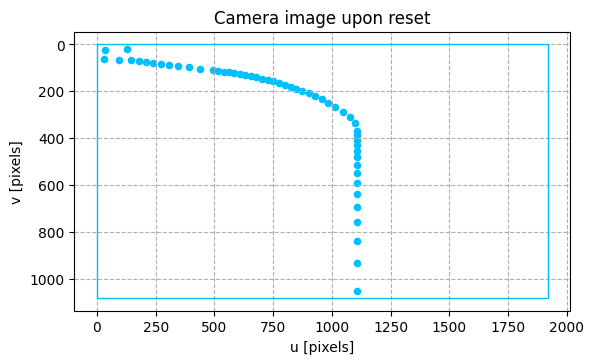

In [366]:
alfg = AutonomousLineFollowingGym()

uv_coords, info_dict = alfg.reset()

#print("Camera pixel coordinates upon reset:")
#print(uv_coords)


# Plot the pixels
# > Open a figure and axis
fig, axs = plt.subplots(1, 1, sharex=True, sharey=False, gridspec_kw={"hspace": 0.2, "wspace": 0.4})
# > Plot the pixels
uv_pixels_handle = axs.scatter(uv_coords[:,0],uv_coords[:,1], linewidth=0, marker="o", color = "deepskyblue", s=30)
# > Plot the visible region
w = alfg.camera_resolution_width
h = alfg.camera_resolution_height
uv_visible_handle = axs.plot([0,w,w,0,0],[0,0,h,h,0], linewidth=1, marker=None, color = "deepskyblue")
# > Add labels and grid
axs.set_xlabel('u [pixels]')
axs.set_ylabel('v [pixels]')
axs.invert_yaxis()
axs.grid(visible=True, which="both", axis="both", linestyle='--')
axs.set_title("Camera image upon reset")
# Set the aspect ratio so that box axes are equal scale
axs.set_aspect('equal', adjustable='box')

## (C) Step

This is the core function of any gymnasium-like environemnt. As mentioned above, the step function:

  * Takes as input the action to apply to the bicycle model.
  * Computes the evolution of the bicycle model for one time-step.
  * Return the observation from the camera point of view and additional "ground truth" data about the car.

In [367]:
class AutonomousLineFollowingGym(AutonomousLineFollowingGym):

    @classmethod
    def step(self, v_request, delta_request, Ts=0.05):
        """
        Steps forward in time the model of the car by Ts seconds and then
        generates the line-detection observation of the camera.

        Parameters
        ----------
            v_request : float
                The requested value for the velocity, i.e., the target. See the
                documentation of the kinematic bicycle model class for more
                details (units: m/s).
            delta_request : float
                The requested value for the steering angle, i.e., the target.
                See the documentation of the kinematic bicycle model class for
                more details (units: radians).
            Ts : float
                The duration for how far forward-in-time to step the car
              (units: seconds).

        Returns
        -------
            uv_coords : numpy array
                Same definition as for the reset function (units: pixels).
            info_dict : dictionary
                Same definition as for the reset function
        """
        # Set the action request for bike model
        self.car.set_action_requests(v_request = v_request, delta_request = delta_request)

        # Perform one integration step
        self.car.perform_integration_step(Ts, self.integration_method, num_steps = 1, should_update_state = True)

        # Get the camera observation of the car's camera
        uv_coords, info_dict = self.road_env.line_detection_pixels_for_given_pose(self.car.px, self.car.py, self.car.theta, self.R_BtoC, self.T_CtoB_inB, self.intrinsic_matrix, self.camera_resolution_width, self.camera_resolution_height )

        # Return the camera observation
        return uv_coords, info_dict


## (D) Run a simple simulation

As "simple" as possible to match the typical Gymnasium examples.

In [368]:
# Specify simulation length by:
# > Number of steps
N_sim = 300
# > Time increment per simulation step (units: seconds)
Ts_sim = 0.1

# Initialise array for storing the state and action trajectories
px_traj    = np.empty([N_sim+1,], dtype=np.float32)
py_traj    = np.empty([N_sim+1,], dtype=np.float32)
theta_traj = np.empty([N_sim+1,], dtype=np.float32)
v_traj     = np.empty([N_sim+1,], dtype=np.float32)
delta_traj = np.empty([N_sim+1,], dtype=np.float32)

v_request_traj     = np.empty([N_sim,], dtype=np.float32)
delta_request_traj = np.empty([N_sim,], dtype=np.float32)

# Instantiate an ALF-g
alfg = AutonomousLineFollowingGym()

# Reset for getting the initial observation
uv_coords, info_dict = alfg.reset()

# Put the initial condition into the first entry of the state trajectory results
px_traj[0]    = alfg.car.px
py_traj[0]    = alfg.car.py
theta_traj[0] = alfg.car.theta
v_traj[0]     = alfg.car.v
delta_traj[0] = alfg.car.delta

# Record the start time
start_time = perf_counter()

# Initialize a counter for the number of observation with no uv_coords
counter_uv_coords_isempty = 0

# Iterate over the simulation horizon
for k_sim_step in np.arange(0,N_sim):

    # Compute the VELOCITY action
    # > Always request a constant velocity
    v_request = 2.0

    # Compute the STEERING action
    # > Proportional to the u-coordinate of the first pixel on the line
    # > Choose to have 40 degrees steering at 800 pixel
    # > Need to offset the u-cordinate by half the resolution width
    if (uv_coords.shape[0] > 0):
        this_u = uv_coords[0,0] - 960.
        delta_request = -40.0 * (np.pi/180) * (this_u/800.)
    else:
        delta_request = 0.0
        counter_uv_coords_isempty = counter_uv_coords_isempty + 1

    # A "bang-bang" control policy:
    #delta_request = -15.0 * (np.pi/180) * info_dict["side_of_the_road_line"]

    if (counter_uv_coords_isempty>10):
        v_request = 0.0

    #print("(u,delta) = " + str(this_u) + " , " + str(delta_request))

    # Step the environment forward
    uv_coords, info_dict = alfg.step(v_request, delta_request, Ts_sim)

    # Store the results
    # > For the action requests
    v_request_traj[k_sim_step]     = v_request
    delta_request_traj[k_sim_step] = delta_request
    # > For the "actual" actions
    #Dv, Ddelta = bike_model.get_actions()
    #Dv_traj[int_method_idx, k_sim_step]     = Dv
    #Ddelta_traj[int_method_idx, k_sim_step] = Ddelta
    # > For the updated state
    px_traj[k_sim_step+1]    = alfg.car.px
    py_traj[k_sim_step+1]    = alfg.car.py
    theta_traj[k_sim_step+1] = alfg.car.theta
    v_traj[k_sim_step+1]     = alfg.car.v
    delta_traj[k_sim_step+1] = alfg.car.delta

# Record the end time of this simulation run
end_time = perf_counter()

# Compute the simualation time
sim_time = end_time - start_time

# Print out a simple statement of the timing results
print("Completed simulation of " + str(N_sim) + " time steps for method = " + "{:<10}".format(int_method) + ", in " + '{0:10.6f}'.format(sim_time) + " seconds.\n" )

Completed simulation of 300 time steps for method = rk45      , in   0.398955 seconds.



Now plot the simulation results

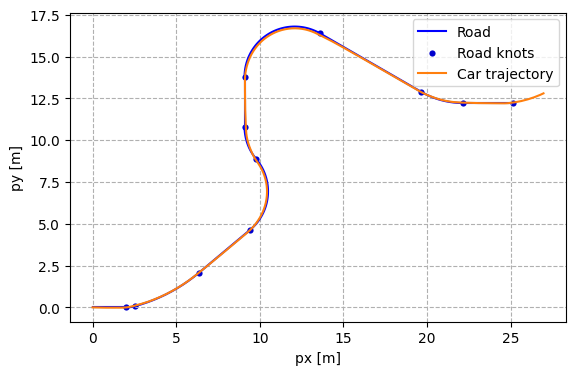

In [369]:
# Plot the road constructed so far
# > Open a figure and axis
fig, axs = plt.subplots(1, 1, sharex=True, sharey=False, gridspec_kw={"hspace": 0.2, "wspace": 0.4})
# > Call the plot function of the road environment
road_element_handles = alfg.road_env.render_road(axs)
# > Set the colour of all the line sections
for handle in road_element_handles: handle.set_color("blue")
# > Add labels and grid
axs.set_xlabel('px [m]')
axs.set_ylabel('py [m]')
axs.grid(visible=True, which="both", axis="both", linestyle='--')
# > Add a label for the legend
road_element_handles[0].set_label("Road")

# Set the aspect ratio so that box axes are equal scale
axs.set_aspect('equal', adjustable='box')

# Plot the end points of each road element so that it is easier to visually check the results
end_points = road_env.get_end_points()
road_knots_handle = axs.scatter(end_points[:,0],end_points[:,1], linewidth=0, marker="o", color="mediumblue", s=20)
# > Add a label for the legend
road_knots_handle.set_label("Road knots")

# Plot the trajectory
traj_handle = axs.plot(px_traj,py_traj)
# > Add a label for the legend
traj_handle[0].set_label("Car trajectory")

# Make things look nice
axs.set_xlabel('px [m]')
axs.set_ylabel('py [m]')
axs.legend(loc = 'upper right')
axs.grid(visible=True, which="both", axis="both", linestyle='--')

## Comparison to the standard Farama Gymnasium interface

Compare the above code with the prototypical examlpe from [the Farama Gymnasium website](https://gymnasium.farama.org/) for using a Gymnasium environment:


``` python
import gymnasium as gym
env = gym.make("LunarLander-v2", render_mode="human")
observation, info = env.reset(seed=42)
for _ in range(1000):
   action = env.action_space.sample()  # this is where you would insert your policy
   observation, reward, terminated, truncated, info = env.step(action)

   if terminated or truncated:
      observation, info = env.reset()

env.close()
```

If we remove all the "fluff" for saving results, then ALF-g is just as simple as this Gymnasium example. The Farama Gymnasium examples all include nice animated visualization of the system, hence this baseline example without any plotting "fluff" is still meaningful. We choose not to include any "fancy" animation in ALF-g because the intention is to simulation many many simulations, hence we are more interesting in analyzing the combined results of all simulation than having a asthetically beausiful visualization of just one simulation. That said, an asthetically beausiful visualization of one simulation can at times be very useful for motivation and insight.

The following give the ALF-g simulation in this same minimal example format:

``` python
alfg = AutonomousLineFollowingGym()
uv_coords, info_dict = alfg.reset()
for _ in range(1000):
    # Specifiy the actions
    v_request = 2.0
    delta_request = 10.0 * (np.pi/180) * uv_coords
    # Step forwards the simulation
    uv_coords, info_dict = alfg.step(v_request, delta_request, Ts_sim)

```

